
# ***Previsão de vendas***
**Responsáveis: Carlos Silva**
**XX/05/2022**
----


# 👀Problema
É preciso entender como as vendas se comportarão no próximo mês para gerenciar estoque e fazer estimativa de receita.
___




# 💭Proposta

- Transformar dados de ordens de compra finalizadas em pedidos diários
- Analise exploratória e decomposição de série temporal 
- ETL de tabelas para unuficar agrupamentos de nível 1 e 2
- Diagrama Sankey para verificar migração de usuários
- Teste de Hipóteses


# 📚 Imports

In [1]:
# Pacotes para processamento de dados
import pandas as pd
import numpy as np

#Pacotes para vizualisação de dados
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Pacotes para MLOps
import mlflow
from pathlib import Path


# 💽 Dataset

In [5]:
orders = pd.read_csv("../data/raw/orders_dataset_raw.csv",
                        #nrows=100,
                        dtype={'order_item_id': str},sep=",",
                        parse_dates = ['order_approved_at'],usecols=['order_id','order_approved_at']
                        )              
orders.info(show_counts=True)
display(orders.head())
print(orders.isnull().sum())
#Teste

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_id           99441 non-null  object        
 1   order_approved_at  99281 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 1.5+ MB


,order_id,order_approved_at
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 03:24:27
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:55:23
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:45:59
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 22:20:29


order_id               0
order_approved_at    160
dtype: int64


In [6]:
orders = pd.read_csv("../data/raw/orders_dataset.csv",
                        #nrows=100,
                        dtype={'order_item_id': str},sep=";",
                        parse_dates = ['order_approved_at'],usecols=['order_id','order_approved_at']
                        )              
orders.info(show_counts=True)
display(orders.head())
print(orders.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99154 entries, 0 to 99153
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_id           99154 non-null  object        
 1   order_approved_at  98994 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 1.5+ MB


,order_id,order_approved_at
0,bfbd0f9bdef84302105ad712db648a6c,2016-09-15 12:16:00
1,1ff217aa612f6cd7c4255c9bfe931c8b,2016-04-10 09:43:00
2,65d1e226dfaeb8cdc42f665422522d14,2016-04-10 10:18:00
3,cd3b8574c82b42fc8129f6d502690c3e,2016-04-10 10:19:00
4,ed8c7b1b3eb256c70ce0c74231e1da88,2016-04-10 10:25:00


order_id               0
order_approved_at    160
dtype: int64


# ⚙️ ETL


In [8]:
def AgregateDf(df,columns,DateCol,setDateName="ds"):
    #Existem várias ordens de compra executadas por dia, essa função calcula o total diário.
    df = df[columns].copy()
    
    df[DateCol] = pd.to_datetime(df[DateCol]).dt.date
    df = df.groupby(DateCol,as_index=False).count()
    df.columns = [ setDateName,"count"]
    df[setDateName] = pd.to_datetime(df[setDateName]).dt.date
    return df.sort_values(setDateName)

def CleanDiffDaysGap(df,DateCol='ds'):
    df['diferenca_dias'] = df[DateCol].diff().dt.days
    StartSiseDf = len(df)
    StartSliceClean= df[df['diferenca_dias']>7.0]['ds'].max()
    df = df[df['ds']>=StartSliceClean].copy()
    FinishSiseDf = len(df)
    ChangeCut = 1-(FinishSiseDf/StartSiseDf)
    print(f"O dataset diminuiu em {ChangeCut:.0%}")
    df.drop(columns='diferenca_dias',inplace=True)
    return df

def InterpolateSerie (df,DateCol='ds',InterpolateCol = 'count', order = 7):
    df = df.copy()
    df.set_index(DateCol,inplace=True)
    df =df.asfreq('D')
    df[InterpolateCol] = df[InterpolateCol].interpolate(method='linear', order=order)
    return df



orders.dropna(subset=['order_approved_at'],inplace=True)    
orders_daily = AgregateDf(orders,['order_id','order_approved_at'],'order_approved_at')
orders_daily = CleanDiffDaysGap(orders_daily,DateCol='ds')
orders_daily = InterpolateSerie(orders_daily,DateCol='ds')
orders_daily.columns=['Qt_Pedidos'] #Posso colocar isso dentro da função
orders_daily.to_csv("C:\WIMYD\MasterOfDices\data\processed\process01_daily_orders_clean.csv")
orders_daily

O dataset diminuiu em 99%


,Qt_Pedidos
ds,
2018-12-01,261
2018-12-02,179
2018-12-03,192
2018-12-04,152
2018-12-05,218
2018-12-06,292
2018-12-07,129
2018-12-08,160


In [109]:
orders_daily

,Qt_Pedidos
ds,
2018-12-01,261
2018-12-02,179
2018-12-03,192
2018-12-04,152
2018-12-05,218
2018-12-06,292
2018-12-07,129
2018-12-08,160


# 📈 Série temporal de vendas

In [4]:
px.line(orders_daily,
        y='Qt_Pedidos',
        #x='date',
        title="Série temporal de vendas").show()

# Engenharia de variáveis

## Adicionando dados temporais

In [5]:
orders_eda=orders_daily.copy()
orders_eda.reset_index(inplace=True)
orders_eda['Day_Week'] = orders_eda['ds'].dt.weekday
orders_eda['Day_Month'] = orders_eda['ds'].dt.day
orders_eda['Day_Year'] = orders_eda['ds'].dt.dayofyear
orders_eda['Week'] = orders_eda['ds'].dt.isocalendar().week 
orders_eda['Month'] = orders_eda['ds'].dt.month
orders_eda['Quarter'] = orders_eda['ds'].dt.quarter
orders_eda['Year'] = orders_eda['ds'].dt.year
orders_eda.sort_values('ds', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last', ignore_index=False, key=None)
orders_eda['Mes_ano'] = orders_eda['ds'].to_numpy().astype('datetime64[M]')



# Analise exploratória de dados

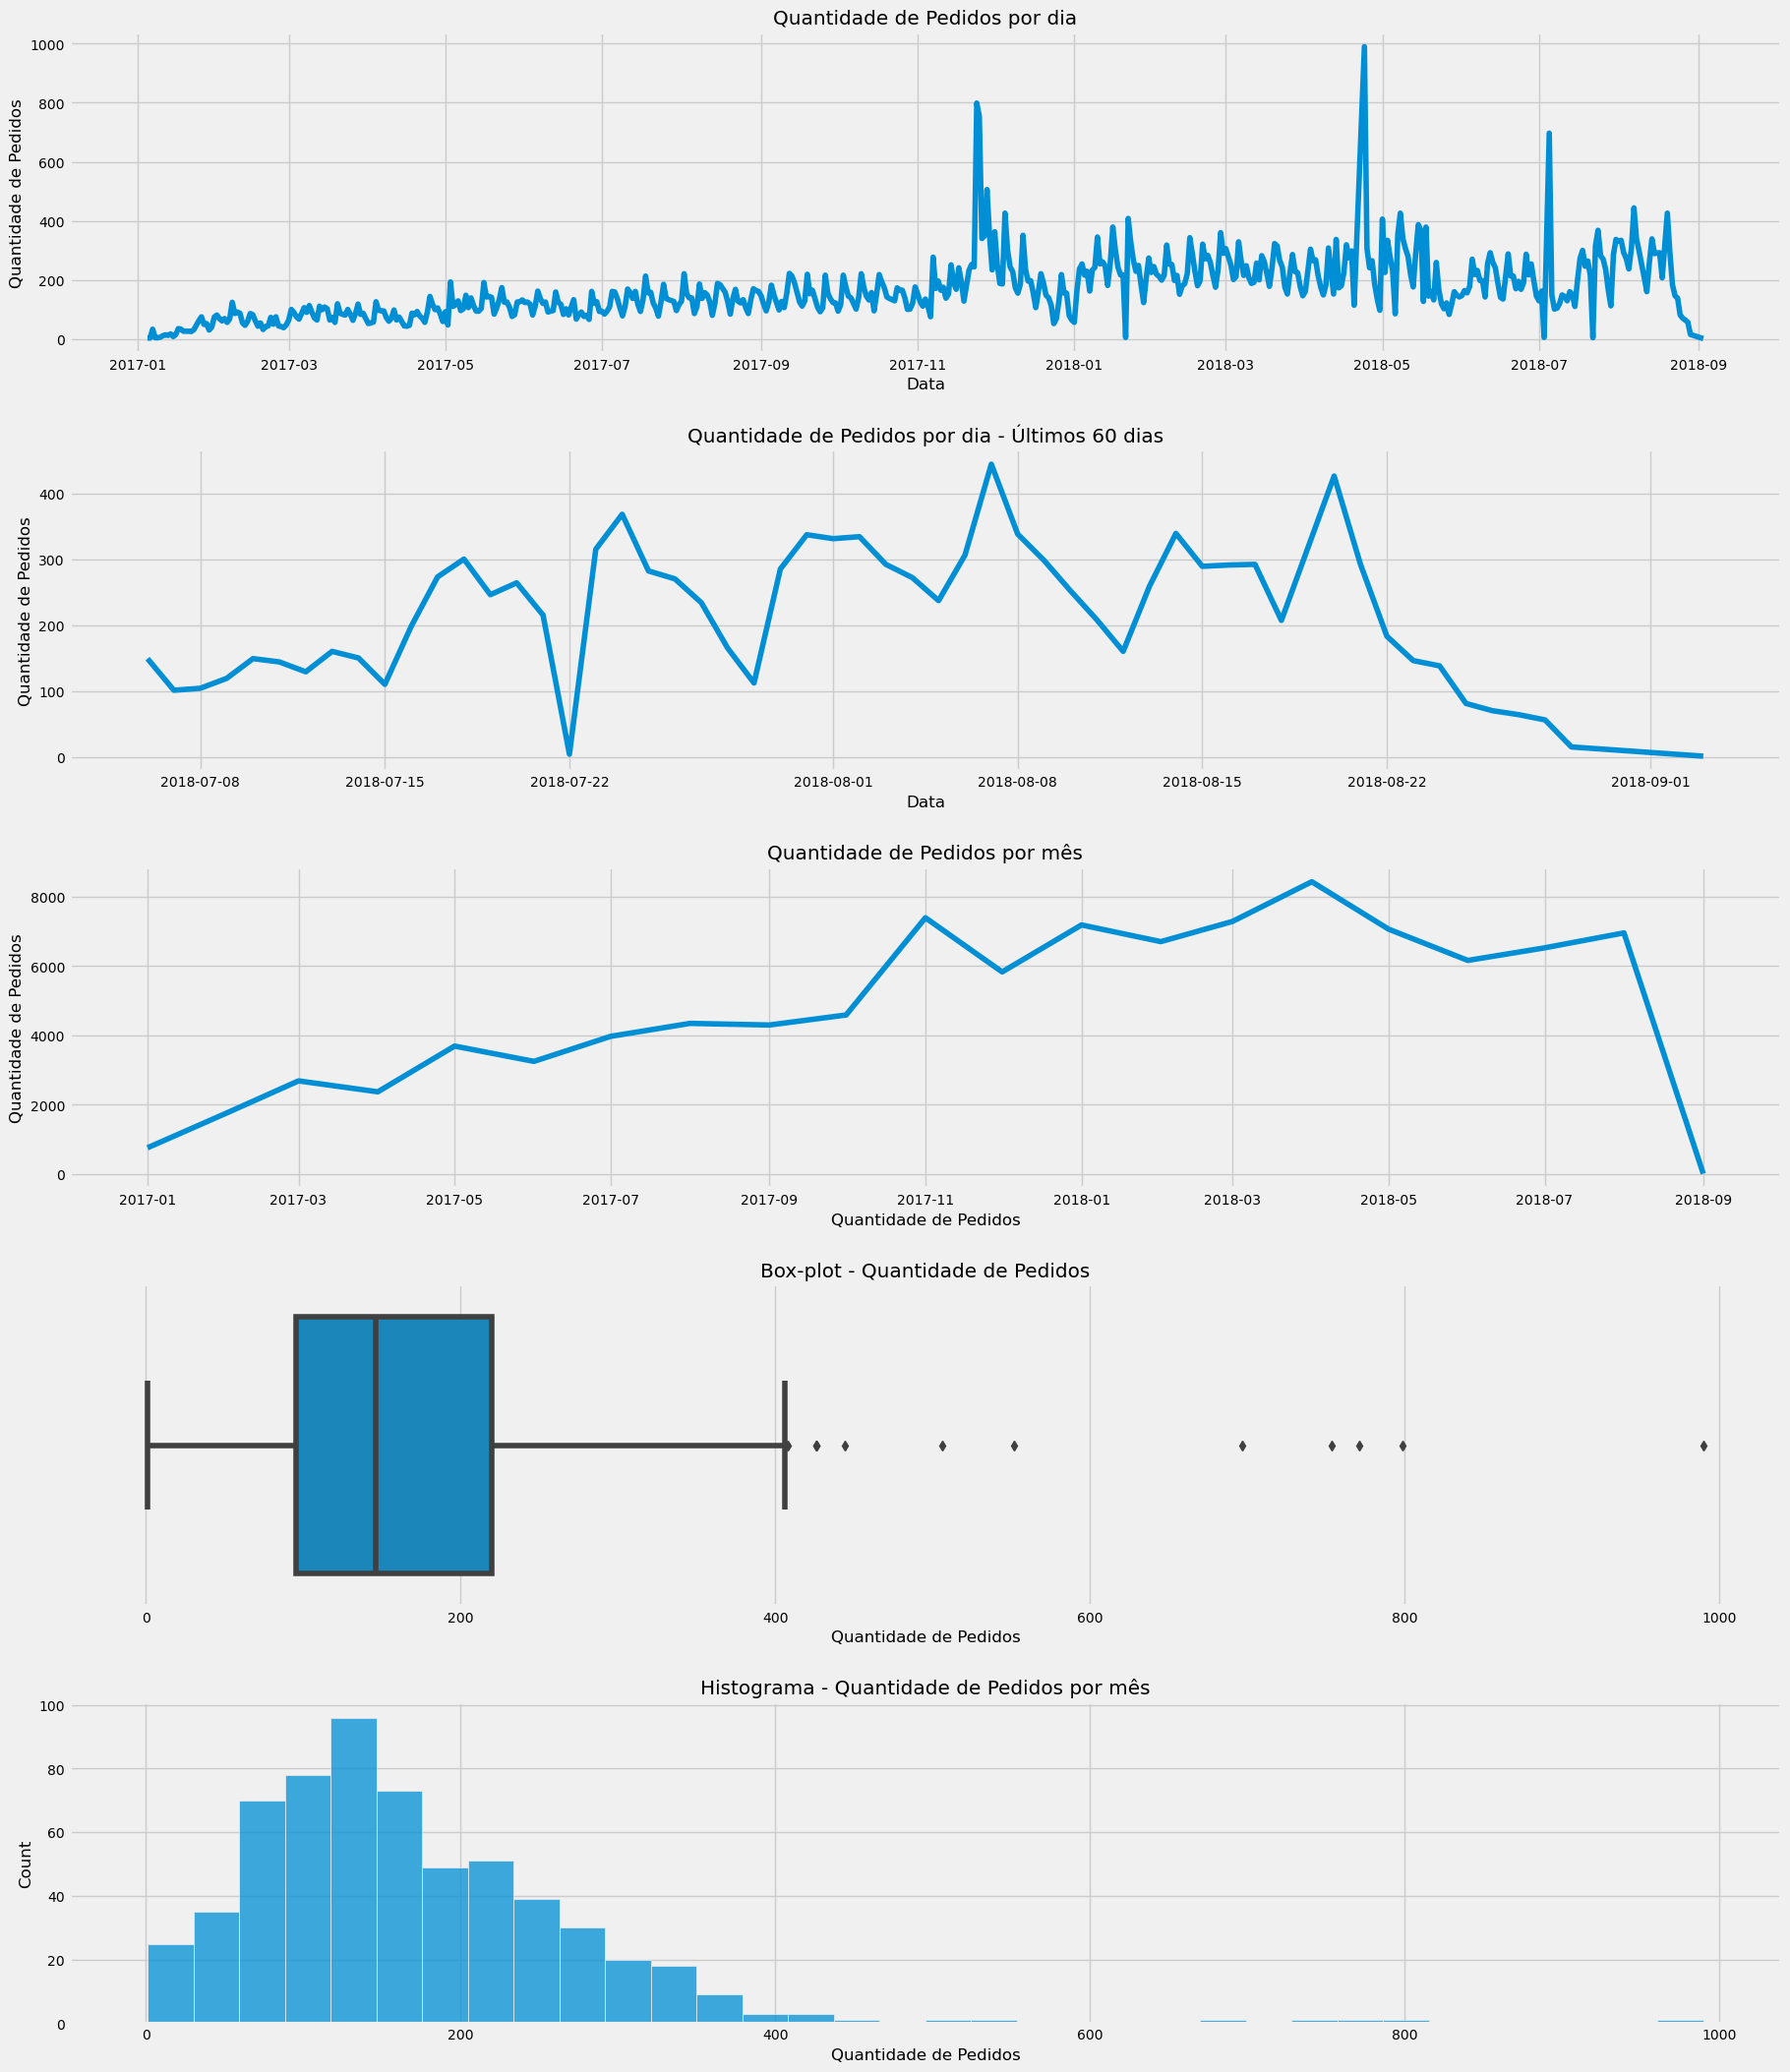

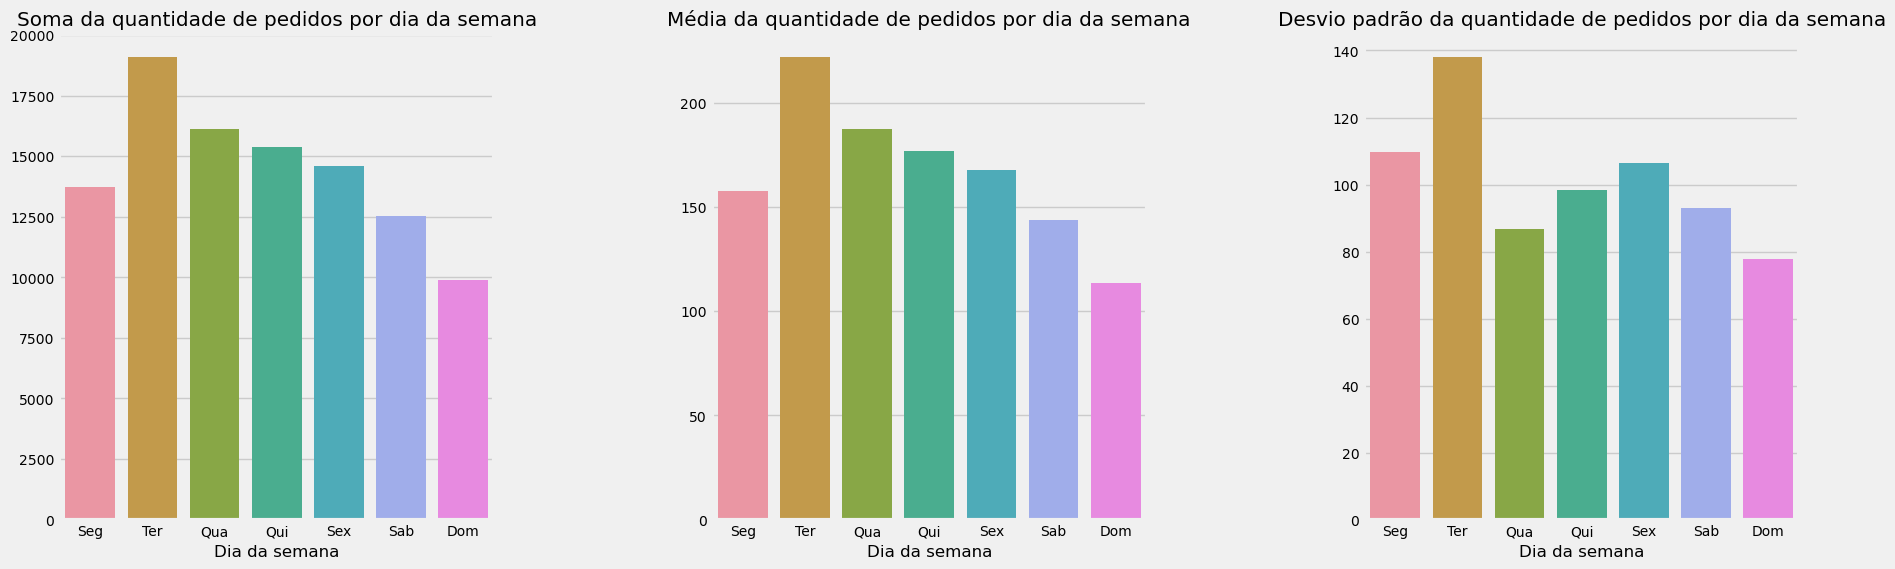

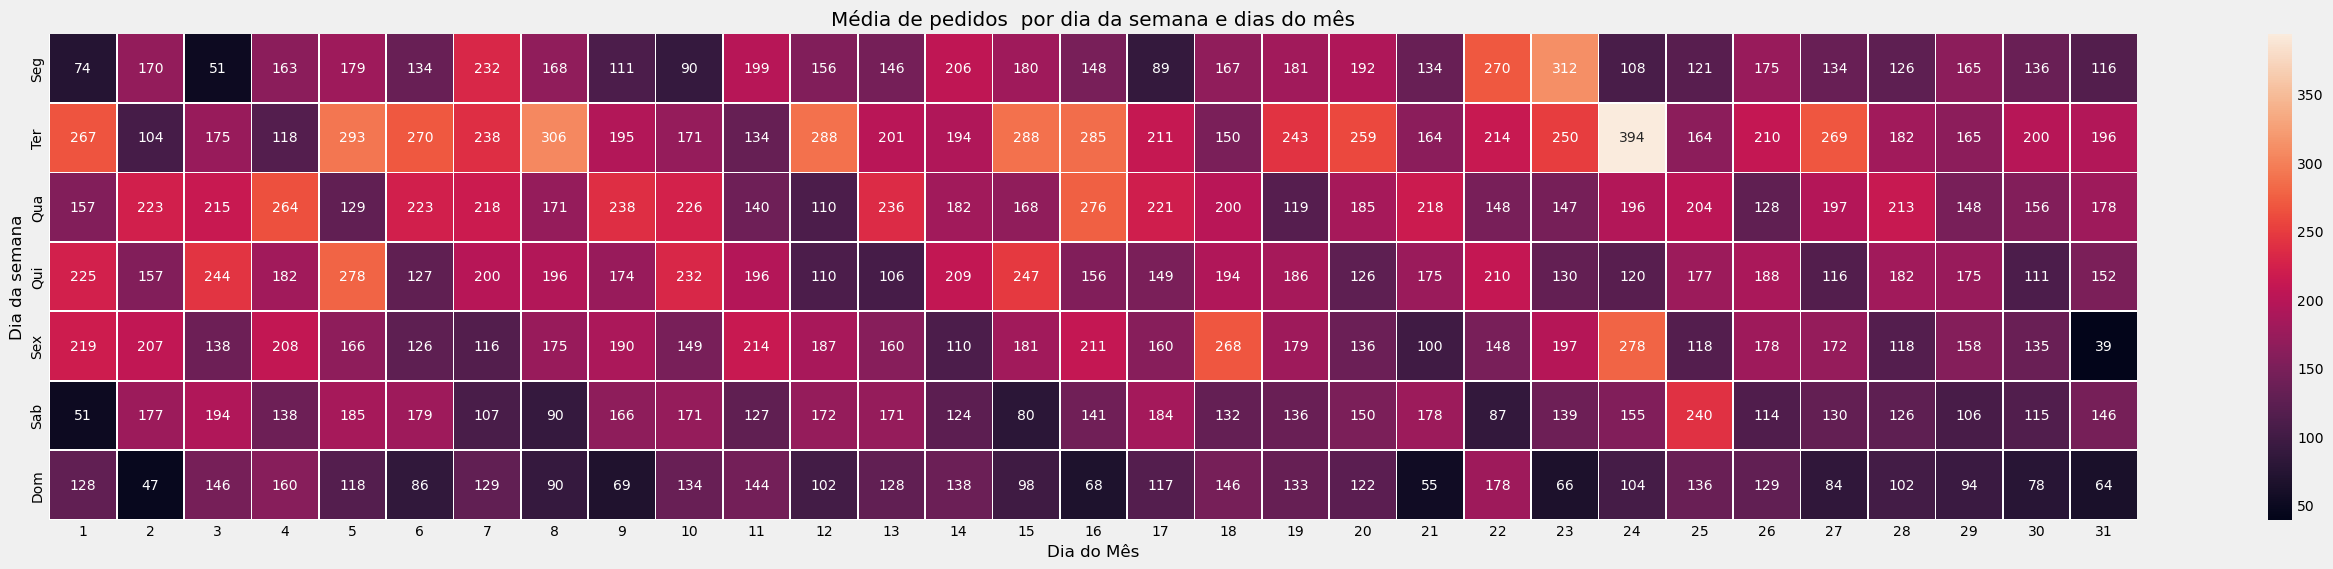

In [6]:
venda_serie_mes = orders_eda[['Mes_ano','Qt_Pedidos']].groupby(['Mes_ano'],as_index=True).sum()

Day_Week_Decribe = orders_eda[["Day_Week","Qt_Pedidos"]].groupby("Day_Week",as_index=False).agg({"Qt_Pedidos":['sum', 'mean','std']})
Day_Week_Decribe.columns = ['Day_Week','quant_ped_sum', 'quant_ped_mean','quant_ped_std']
Day_Week_Decribe['Day_Week'] = ['Seg','Ter','Qua','Qui','Sex','Sab','Dom']

Week_x_Month	 = pd.pivot_table(orders_eda, values='Qt_Pedidos', index=['Day_Week'],
                    columns=['Day_Month'], aggfunc=np.mean)
Week_x_Month.index = ['Seg','Ter','Qua','Qui','Sex','Sab','Dom']


############################# Grágicos #################################################
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 10})

fig, axs = plt.subplots(5,figsize=(20, 25))

sns.lineplot(data=orders_daily["Qt_Pedidos"],ax=axs[0])
axs[0].set_title('Quantidade de Pedidos por dia')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Quantidade de Pedidos')

sns.lineplot(data=orders_daily["Qt_Pedidos"][-60:],ax=axs[1])
axs[1].set_title('Quantidade de Pedidos por dia - Últimos 60 dias')
axs[1].set_xlabel('Data')
axs[1].set_ylabel('Quantidade de Pedidos')

sns.lineplot(data=venda_serie_mes["Qt_Pedidos"],ax=axs[2])
axs[2].set_title('Quantidade de Pedidos por mês')
axs[2].set_xlabel('Quantidade de Pedidos')
axs[2].set_ylabel('Quantidade de Pedidos')

sns.boxplot(data=orders_daily,x='Qt_Pedidos',ax=axs[3])
axs[3].set_title('Box-plot - Quantidade de Pedidos')
axs[3].set_xlabel('Quantidade de Pedidos')

sns.histplot(data=orders_daily,x='Qt_Pedidos',ax=axs[4])
axs[4].set_title('Histograma - Quantidade de Pedidos por mês')
axs[4].set_xlabel('Quantidade de Pedidos')
plt.subplots_adjust(hspace=0.3)
plt.show()
#####################################################################################

fig, axs = plt.subplots(1,3,figsize=(20, 6))

sns.barplot(data=Day_Week_Decribe,y="quant_ped_sum",x="Day_Week" ,ax=axs[0])
axs[0].set_title("Soma da quantidade de pedidos por dia da semana")
axs[0].set_xlabel('Dia da semana')
axs[0].set_ylabel('')

sns.barplot(data=Day_Week_Decribe,y="quant_ped_mean",x="Day_Week" ,ax=axs[1])
axs[1].set_title("Média da quantidade de pedidos por dia da semana")
axs[1].set_xlabel('Dia da semana')
axs[1].set_ylabel('')

sns.barplot(data=Day_Week_Decribe,y="quant_ped_std",x="Day_Week" ,ax=axs[2])
axs[2].set_title("Desvio padrão da quantidade de pedidos por dia da semana")
axs[2].set_xlabel('Dia da semana')
axs[2].set_ylabel('')
plt.subplots_adjust(wspace=0.5)
plt.show()

###################################################################################

f, ax = plt.subplots(figsize=(30,6))
sns.heatmap(Week_x_Month,
            annot=True,
            fmt="0.0f",
            linewidths=.5, ax=ax)
ax.set_title("Média de pedidos  por dia da semana e dias do mês")
ax.set_xlabel('Dia do Mês')
ax.set_ylabel('Dia da semana')

plt.show()


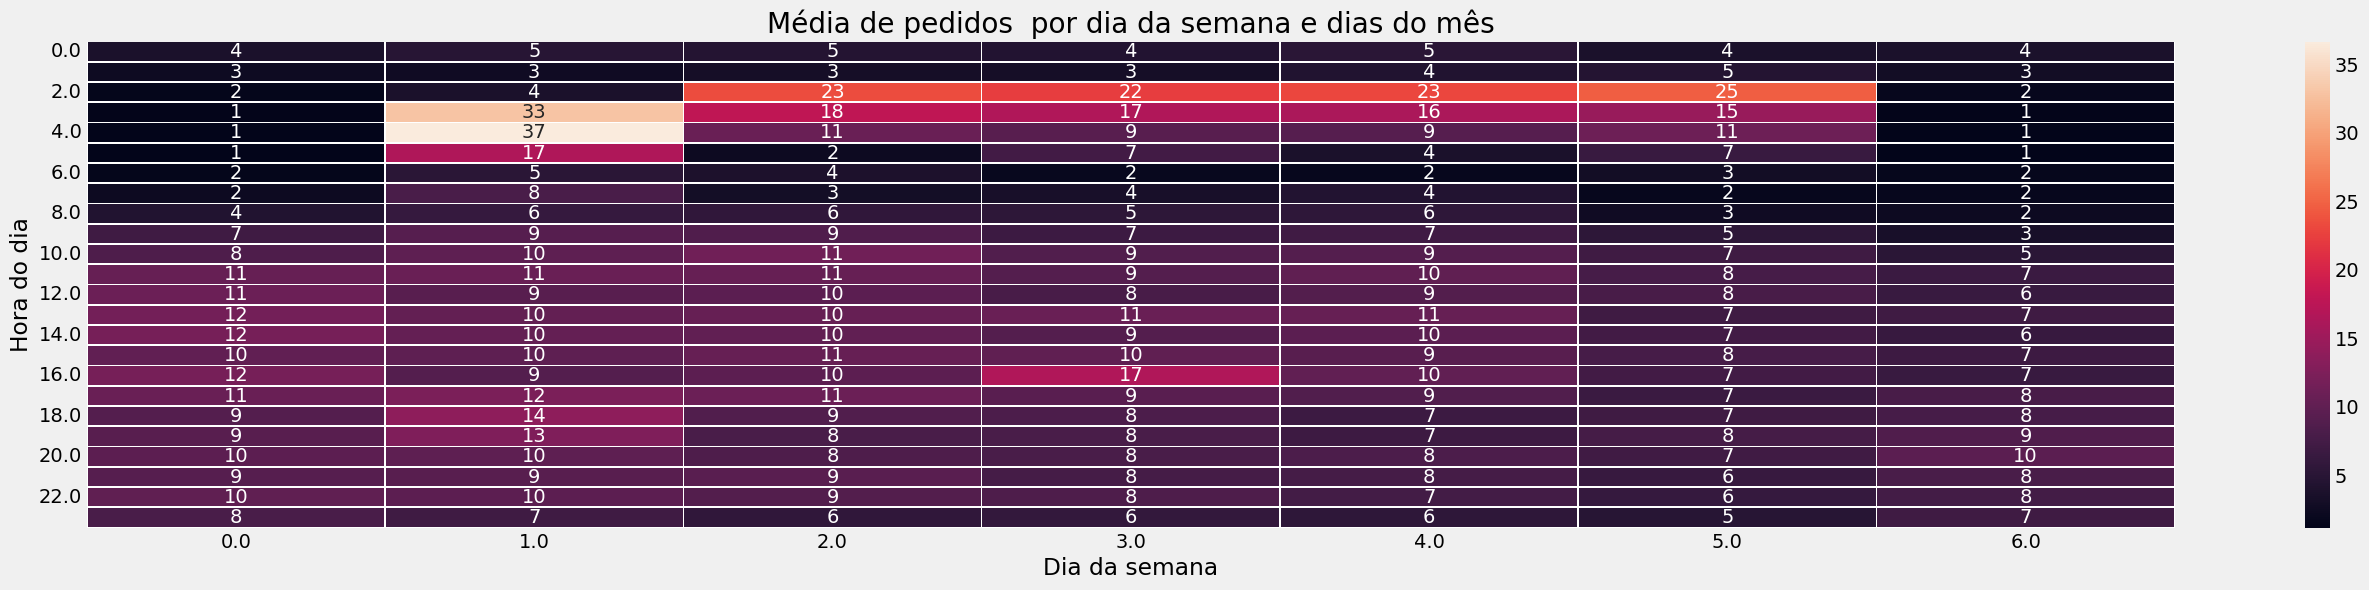

weekday,0.0,1.0,2.0,3.0,4.0,5.0,6.0
HourCol,,,,,,,
0.0,3.676471,4.809524,4.632353,4.402985,5.112903,3.676471,3.781250
1.0,2.508197,2.584615,3.196721,3.173333,4.260870,4.507463,2.934426
2.0,1.578947,3.734694,23.478261,22.301370,23.054054,24.661972,1.800000
3.0,1.440000,32.915254,17.824561,16.666667,16.265306,14.734694,1.360000
4.0,1.277778,36.637931,10.857143,9.322581,9.193548,11.037037,1.181818
5.0,1.200000,16.527778,2.360000,7.333333,3.777778,6.562500,1.235294
6.0,1.534884,5.186441,3.826923,1.982759,1.791667,2.864865,1.700000
7.0,2.314815,7.983871,3.093750,3.523077,4.380952,1.803922,1.780488
8.0,4.309859,6.280000,5.714286,5.360000,5.588235,2.579710,2.301887


In [86]:

orders_v2 = pd.read_csv("../data/raw/orders_dataset.csv",
                        #nrows=100,
                        dtype={'order_item_id': str},
                        parse_dates   = ['order_approved_at'],usecols=['order_id','order_approved_at']
                        ) 
orders_v2['DateCol'] = pd.to_datetime(orders_v2['order_approved_at']).dt.date
orders_v2['HourCol'] = pd.to_datetime(orders_v2['order_approved_at']).dt.hour
orders_v2['weekday'] = orders_v2['order_approved_at'].dt.weekday

OrdersHourWeekday = orders_v2[['order_id','DateCol','HourCol','weekday']].groupby(['DateCol','HourCol','weekday'],as_index=False).count()
OrdersHourWeekday.rename(columns={'order_id':'Pedidos'},inplace=True)
OrdersHourWeekdayMean = pd.pivot_table(OrdersHourWeekday.drop(columns=['DateCol']), values='Pedidos', index='HourCol', columns='weekday', aggfunc='mean')


f, ax = plt.subplots(figsize=(30,6))
sns.heatmap(OrdersHourWeekdayMean,
            annot=True,
            fmt="0.0f",
            linewidths=.5, ax=ax)
ax.set_title("Média de pedidos  por dia da semana e dias do mês")
ax.set_xlabel('Dia da semana')
ax.set_ylabel('Hora do dia')

plt.show()

OrdersHourWeekdayMean

In [87]:
OrdersHourWeekday[['HourCol','weekday','Pedidos']].groupby(['HourCol','weekday']).describe()

Pedidos                                              
                  count      mean       std  min  25%  50%  75%   max
HourCol weekday                                                      
0.0     0.0        68.0  3.676471  3.039252  1.0  2.0  3.0  5.0  21.0
        1.0        63.0  4.809524  4.744631  1.0  2.0  4.0  5.5  28.0
        2.0        68.0  4.632353  2.906012  1.0  2.0  4.0  6.0  11.0
        3.0        67.0  4.402985  3.494843  1.0  2.0  3.0  6.0  23.0
        4.0        62.0  5.112903  7.092145  1.0  2.0  4.0  6.0  54.0
...                 ...       ...       ...  ...  ...  ...  ...   ...
23.0    2.0        80.0  5.750000  3.840161  1.0  3.0  5.0  8.0  18.0
        3.0        82.0  5.951220  4.564767  1.0  3.0  4.5  8.0  29.0
        4.0        83.0  5.554217  8.267263  1.0  2.0  4.0  7.0  74.0
        5.0        74.0  4.797297  3.944755  1.0  2.0  3.5  6.5  21.0
        6.0        78.0  7.051282  5.528903  1.0  3.0  6.0  9.0  28.0

[168 rows x 8 columns]

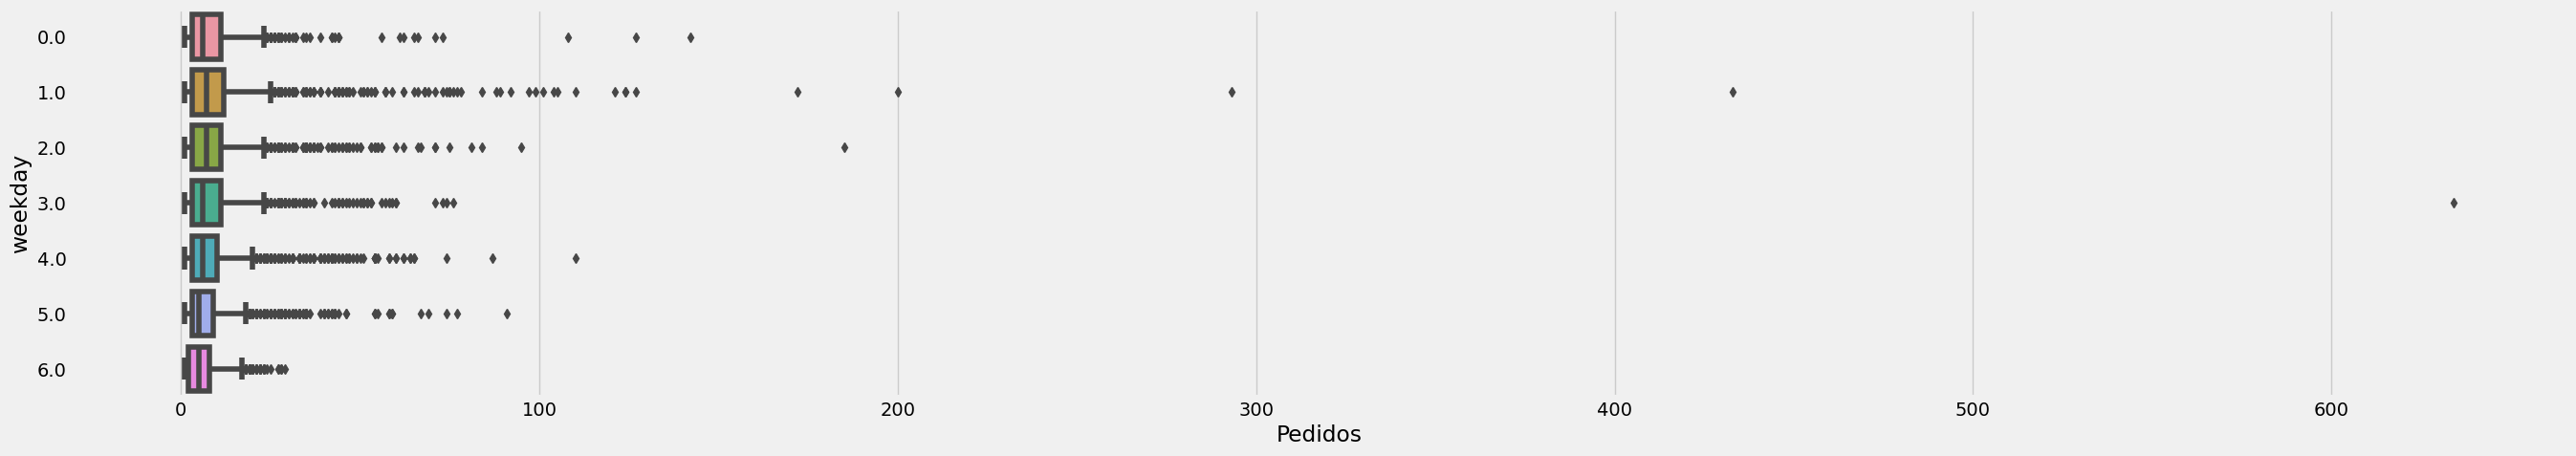

In [88]:
sns.boxplot(data=OrdersHourWeekday, x="Pedidos", y="weekday" ,  orient="h")


In [90]:
OrdersHourWeekday.tail()

,DateCol,HourCol,weekday,Pedidos
11741,2018-08-29,11.0,2.0,1
11742,2018-08-29,12.0,2.0,1
11743,2018-08-29,14.0,2.0,2
11744,2018-08-29,15.0,2.0,2
11745,2018-09-03,17.0,0.0,1


,Qt_Pedidos
ds,
2018-08-20,426.0
2018-08-21,292.0
2018-08-22,183.0
2018-08-23,146.0
2018-08-24,138.0
2018-08-25,81.0
2018-08-26,70.0
2018-08-27,64.0
2018-08-28,56.0


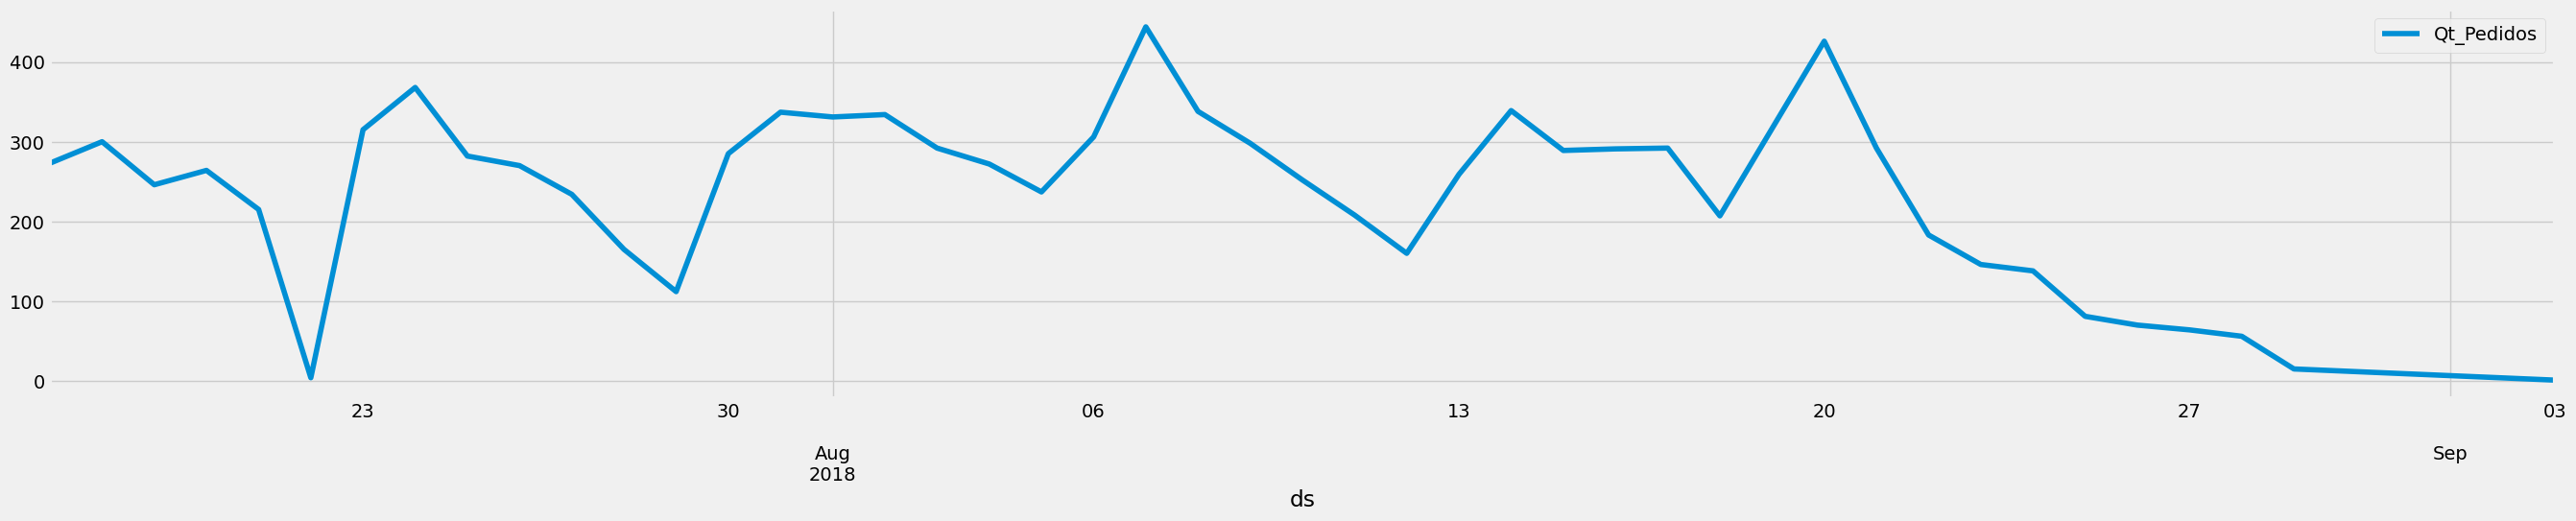

In [100]:
orders_daily.tail(49).plot()
orders_daily.tail(15)

Essas datas tem uma referencia especifica
* Picos em 24 e 25 de 2017/11, Black Friday de 2017

In [8]:
# orders_daily.sort_values('Qt_Pedidos',ascending=False).head(10)

orders_daily[orders_daily['Qt_Pedidos']>600]


,Qt_Pedidos
ds,
2017-11-24,799.0
2017-11-25,754.0
2018-04-23,771.0
2018-04-24,990.0
2018-07-05,697.0


In [9]:
# venda_serie_mes = orders_eda[['Mes_ano','quantidade_pedido']].groupby(['Mes_ano'],as_index=True).mean()
# px.line(venda_serie_mes, x=venda_serie_mes.index, y="quantidade_pedido",title="Pedidos/mês").show()
# px.line(orders_eda, y='quantidade_pedido',x='date',title="Pedidos/dia") .show()
# px.histogram(orders_eda, x="quantidade_pedido",title="Histograma - Pedidos/dia").show()
# px.box(orders_eda, x="quantidade_pedido",title="Box-Plot - Pedidos/dia").show()

In [10]:
"""
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
from dataprep.eda import create_report   # Used to load Report formate
from dataprep.eda import plot
from pylab import rcParams
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from prophet import Prophet
from prophet.serialize import model_to_json
from prophet.serialize import model_from_json
from prophet.plot import add_changepoints_to_plot , plot_cross_validation_metric
from prophet.diagnostics import cross_validation,performance_metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
import itertools
"""


'\nimport pandas as pd\nimport numpy as np\nimport plotly\nimport plotly.express as px\nfrom dataprep.eda import create_report   # Used to load Report formate\nfrom dataprep.eda import plot\nfrom pylab import rcParams\nimport matplotlib.pyplot as plt\n\nfrom statsmodels.tsa.stattools import adfuller\nfrom statsmodels.graphics.tsaplots import plot_acf\n\nfrom prophet import Prophet\nfrom prophet.serialize import model_to_json\nfrom prophet.serialize import model_from_json\nfrom prophet.plot import add_changepoints_to_plot , plot_cross_validation_metric\nfrom prophet.diagnostics import cross_validation,performance_metrics\nfrom sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error\nimport itertools\n'

# Decomposição

In [11]:

from statsmodels.tsa.seasonal import seasonal_decompose

# ts_daily.set_index('dia',inplace=True)
decomposition = seasonal_decompose(orders_daily[['Qt_Pedidos']], model='additive')

## Testando estacionaridade
para p < 0,05 é considerado estacionário 

In [12]:
print(100*"_")
print(f"Testando estacionaridade geral")
from statsmodels.tsa.stattools import adfuller
X = orders_daily[['Qt_Pedidos']]
result = adfuller(X)
print('ADF Estatíticas: %f' % result[0])
print('Valor de P: %f' % result[1])
print('Valores Críticos:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

n=300 #Corte dos dados

print(100*"_")
print(f"Testando estacionaridade até os {n} primeiros valores")
X = orders_daily[['Qt_Pedidos']][:n]
result = adfuller(X)
print('ADF Estatíticas: %f' % result[0])
print('Valor de P: %f' % result[1])
print('Valores Críticos:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

print(100*"_")
print(f"Testando estacionaridade depois dos {n} primeiros valores")

from statsmodels.tsa.stattools import adfuller
X = orders_daily[['Qt_Pedidos']][n:]
result = adfuller(X)
print('ADF Estatíticas: %f' % result[0])
print('Valor de P: %f' % result[1])
print('Valores Críticos:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))


____________________________________________________________________________________________________
Testando estacionaridade geral
ADF Estatíticas: -2.796267
Valor de P: 0.058809
Valores Críticos:
	1%: -3.441
	5%: -2.866
	10%: -2.569
____________________________________________________________________________________________________
Testando estacionaridade até os 300 primeiros valores
ADF Estatíticas: -2.376885
Valor de P: 0.148367
Valores Críticos:
	1%: -3.454
	5%: -2.872
	10%: -2.572
____________________________________________________________________________________________________
Testando estacionaridade depois dos 300 primeiros valores
ADF Estatíticas: -4.088233
Valor de P: 0.001013
Valores Críticos:
	1%: -3.452
	5%: -2.871
	10%: -2.572


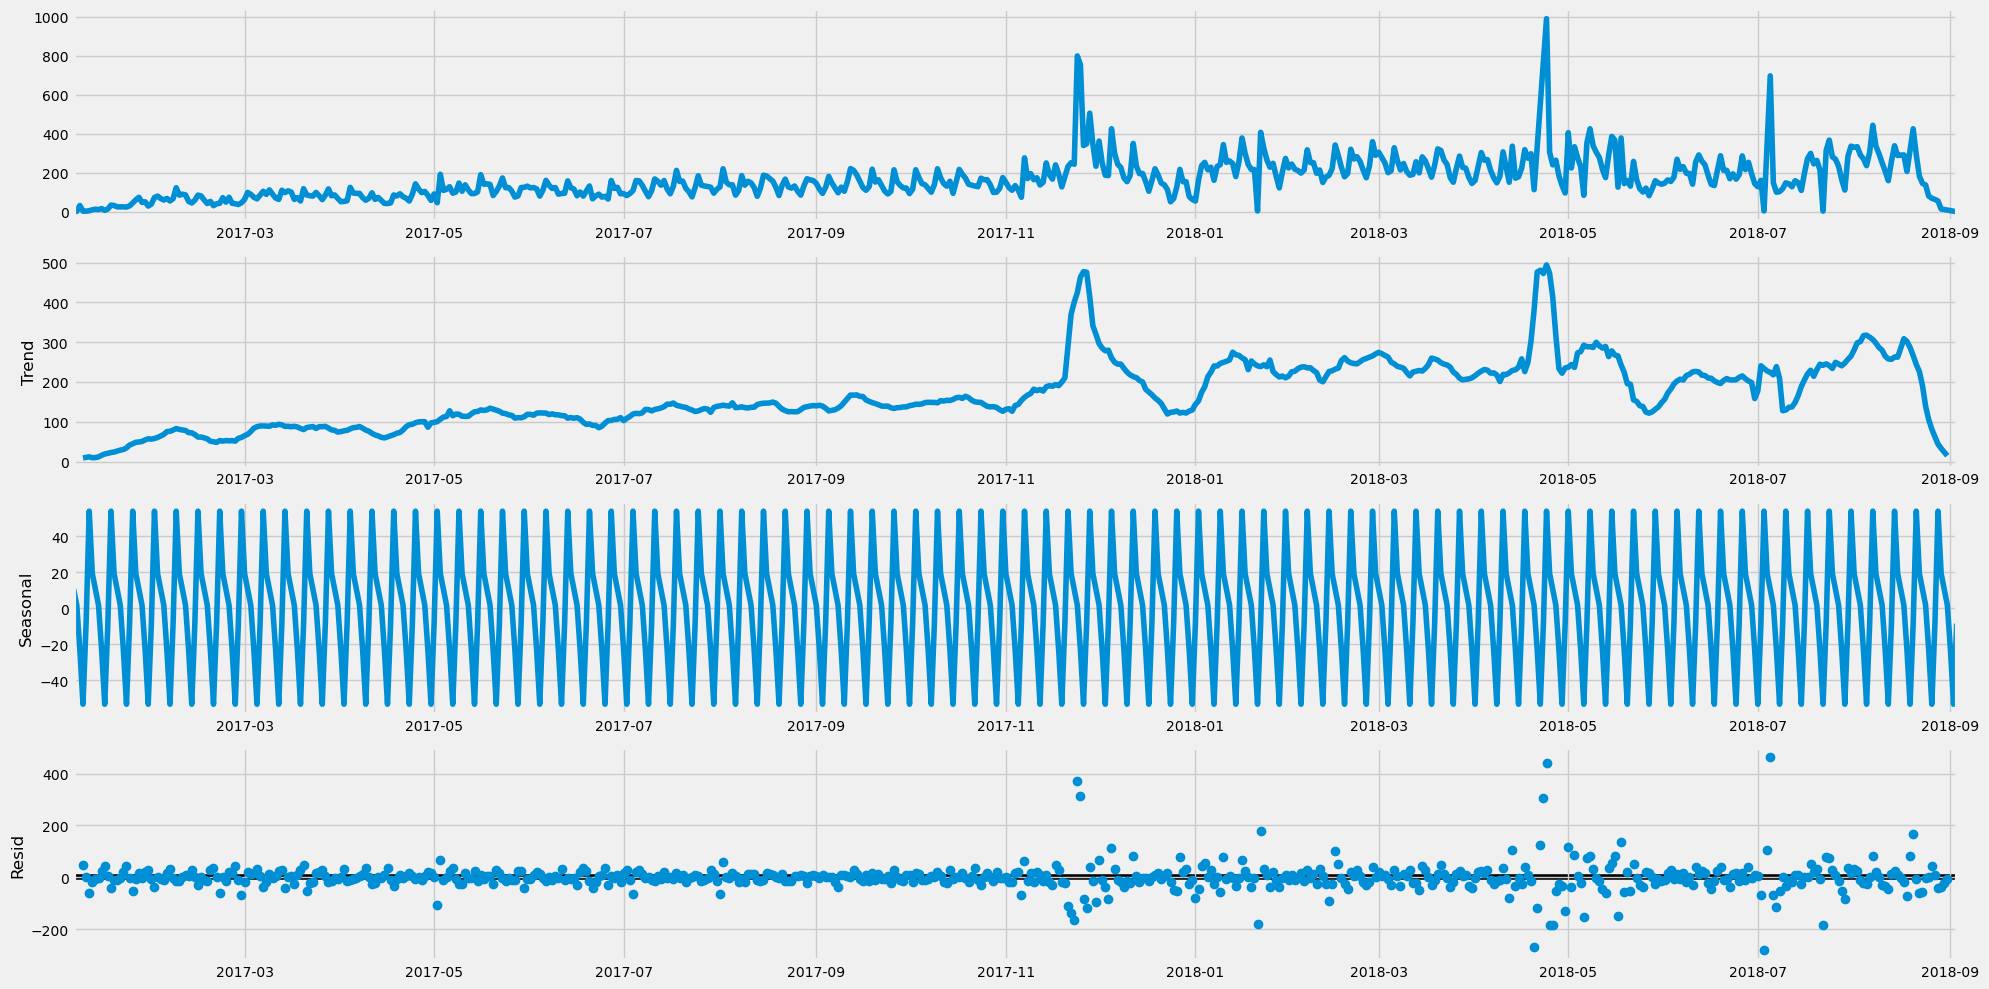

In [13]:
from pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 20, 10
fig = decomposition.plot()
plt.show()

## Sazonalidade

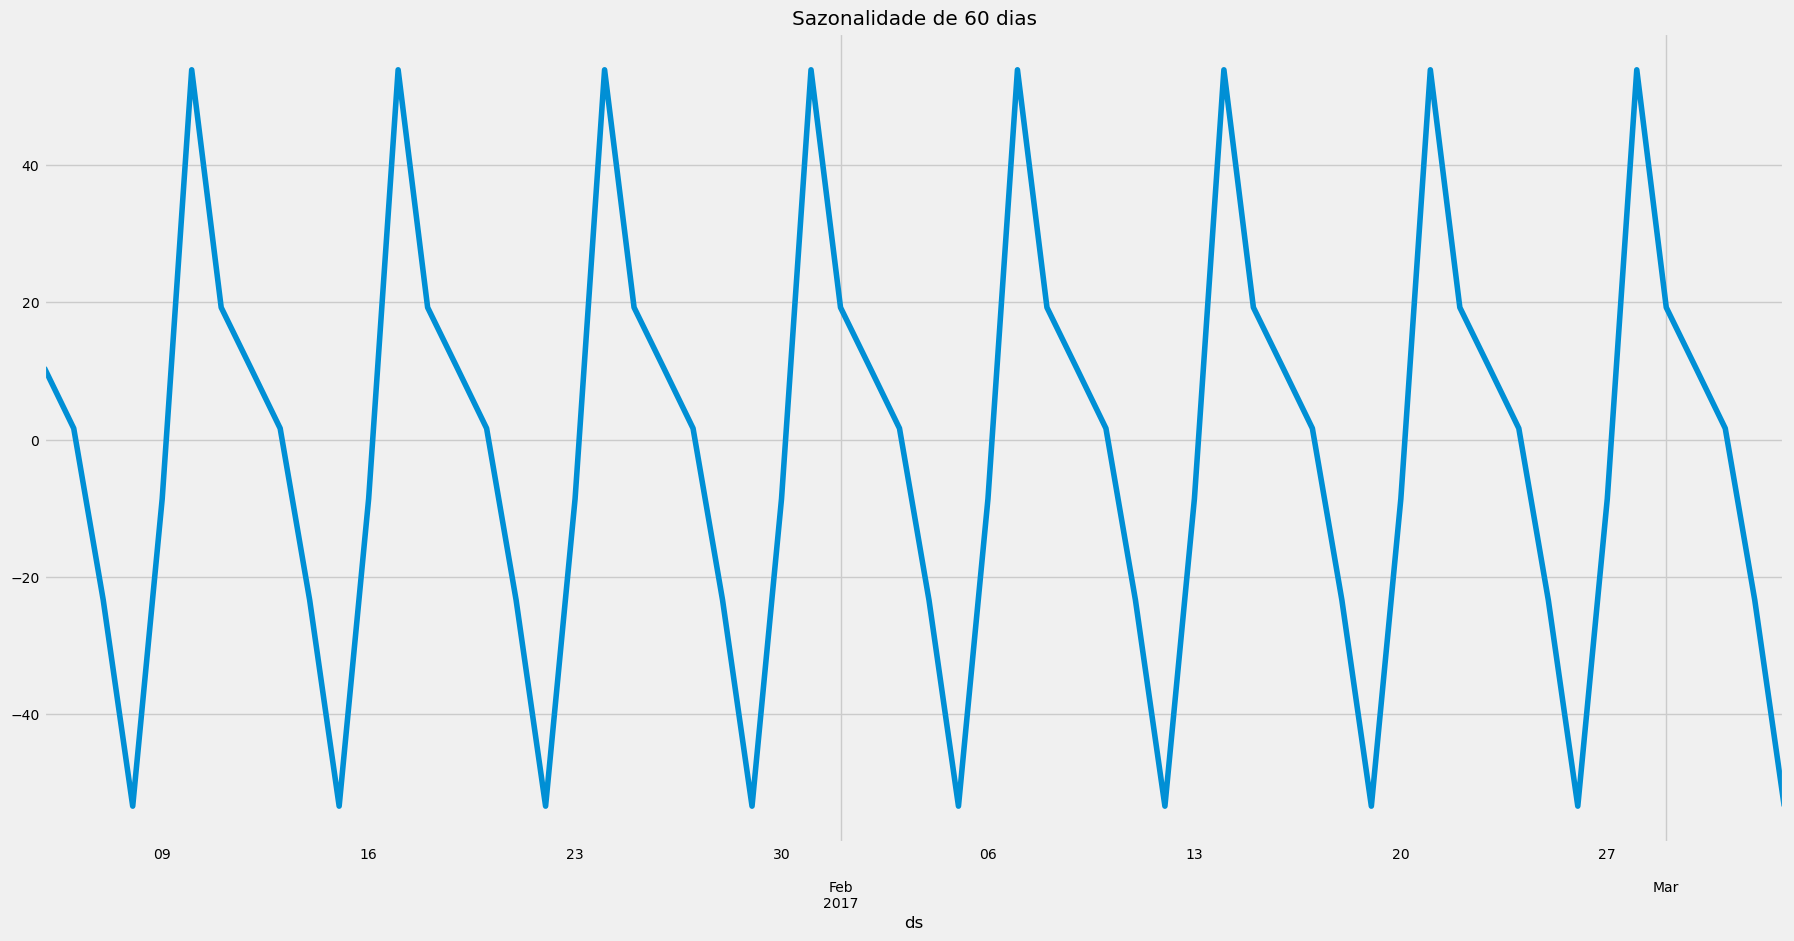

In [14]:
plt.title('Sazonalidade de 60 dias')
rcParams['figure.figsize'] = 10,3
decomposition.seasonal[:60].plot()


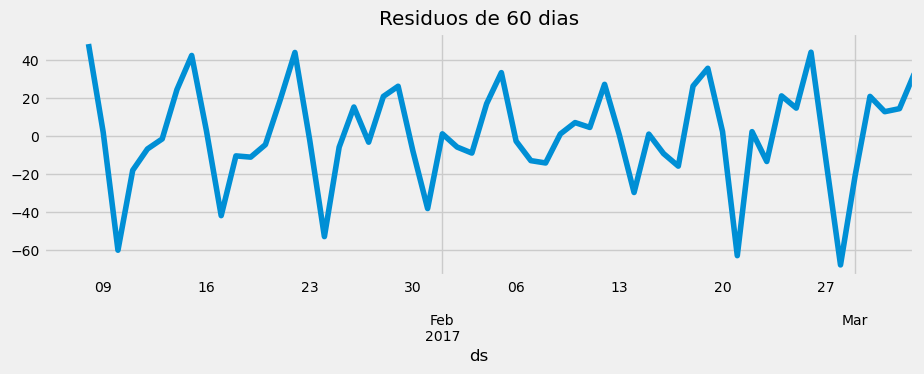

In [15]:
plt.title('Residuos de 60 dias')
rcParams['figure.figsize'] = 30,3
decomposition.resid[:60].plot()

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

## Autocorrelação

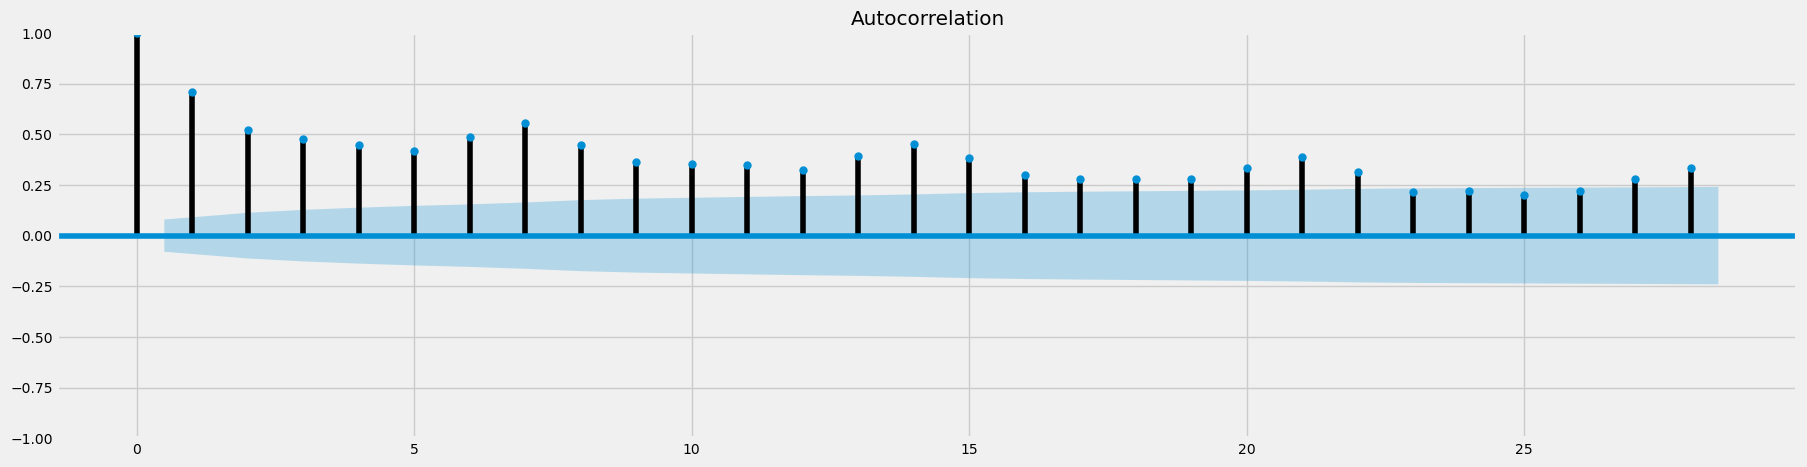

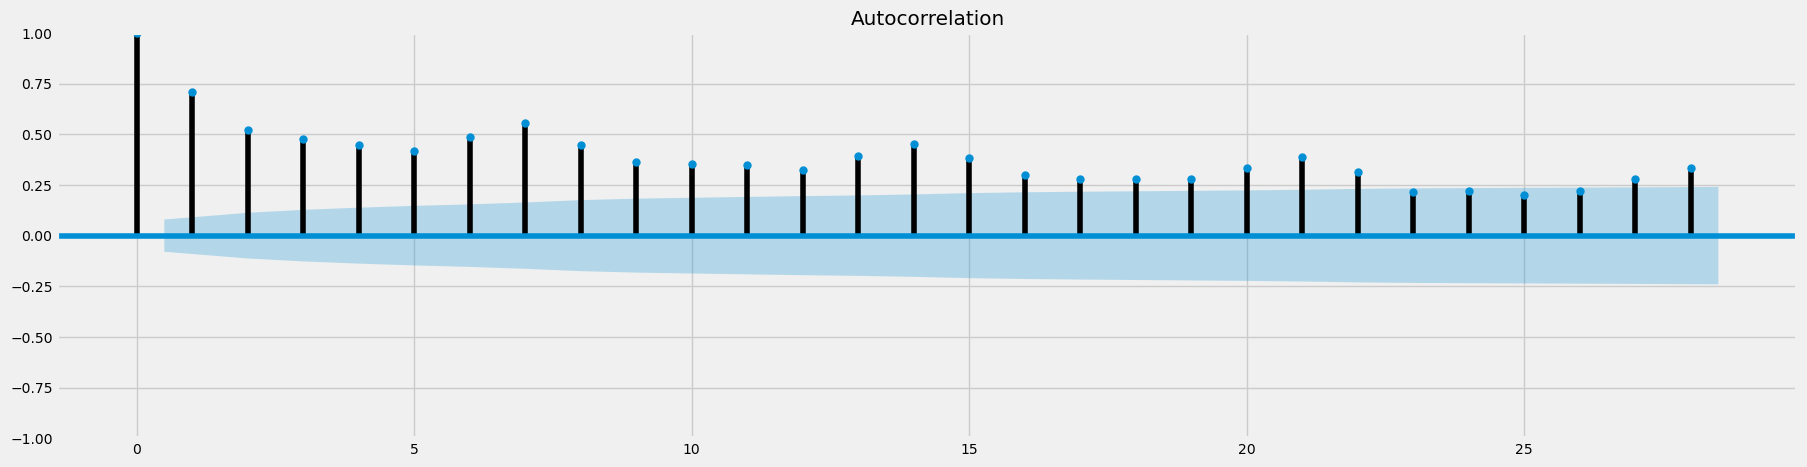

In [17]:
#@title Autocorrelação
rcParams['figure.figsize'] =  20, 5
plot_acf(orders_daily[['Qt_Pedidos']][:],lags=28)


c:\Users\chpsi\anaconda3\envs\Forecast\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



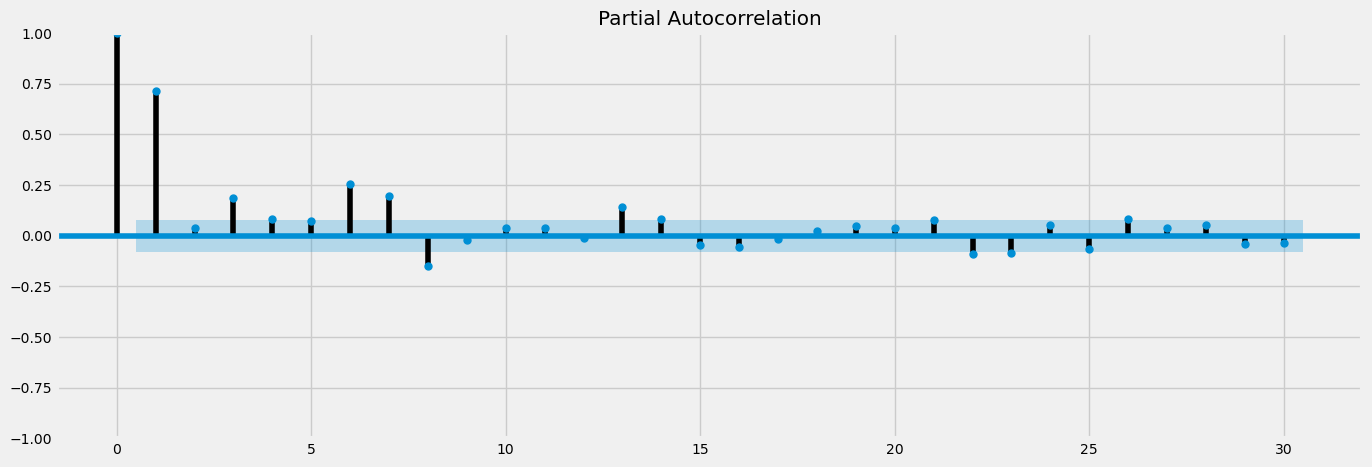

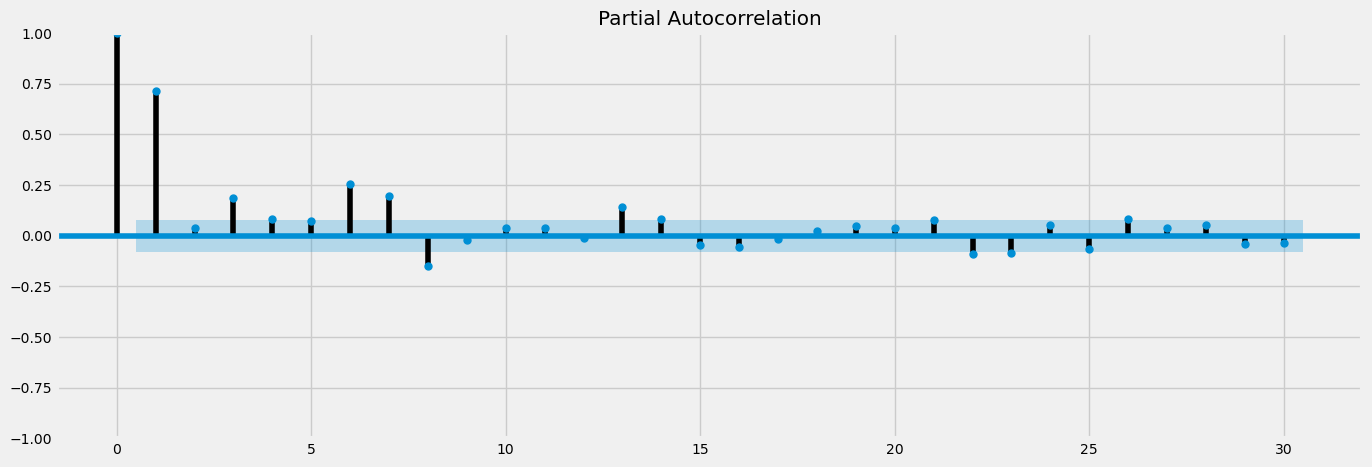

In [18]:
#@title Autocorrelação
rcParams['figure.figsize'] =  15, 5
plot_pacf(orders_daily[['Qt_Pedidos']][:],lags=30)

In [19]:
orders_daily

,Qt_Pedidos
ds,
2017-01-05,3.0
2017-01-06,3.0
2017-01-07,33.0
2017-01-08,4.0
2017-01-09,4.0
...,...
2018-08-30,12.2
2018-08-31,9.4
2018-09-01,6.6


# Treino e teste

In [31]:
len_teste = 30
train = orders_daily[:len(orders_daily)-len_teste]
teste = orders_daily[-len_teste:]


print(f"Treino com {train['Qt_Pedidos'].count()} valores e teste {teste['Qt_Pedidos'].count()}")

Treino com 577 valores e teste 30


In [34]:
train_prophet = train['Qt_Pedidos'].reset_index()
train_prophet.columns = ['ds', 'y']


# Modelagem Prophet

In [35]:
from prophet import Prophet, serialize
from prophet.diagnostics import cross_validation,performance_metrics
import itertools
from prophet.plot import add_changepoints_to_plot , plot_cross_validation_metric


## Modelo Inicial

### Funções

In [36]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

ResultsMetrics = pd.DataFrame(data = {'Model': ['Model'],
                                      'R2_score': [1.0],
                                      'MAE':[1.0],
                                      'MSE': [1.0],
                                      'RMSE':[1.0]})
ResultsMetrics = ResultsMetrics.drop([0])

def MetricsTableAppend(df,ModelName,X,Y):
  R2_score = r2_score(X,Y)
  MAE = mean_absolute_error(X,Y)
  MSE = mean_squared_error(X,Y)
  RMSE = mean_squared_error(X,Y ,squared=False)
  df.loc[len(df.index)] = [ModelName, R2_score, MAE,MSE,RMSE]  
  return df

def MetricsTable(ModelName,X,Y):
  df = pd.DataFrame(data = {'Model': ['Model'],
                                      'R2_score': [1.0],
                                      'MAE':[1.0],
                                      'MSE': [1.0],
                                      'RMSE':[1.0]})
  df = df.drop([0])
  R2_score = r2_score(X,Y)
  MAE = mean_absolute_error(X,Y)
  MSE = mean_squared_error(X,Y)
  RMSE = mean_squared_error(X,Y,squared=False)
  df.loc[len(df.index)] = [ModelName, R2_score, MAE,MSE,RMSE]  
  return df

def extract_params(pr_model):
    return {attr: getattr(pr_model, attr) for attr in serialize.SIMPLE_ATTRIBUTES}

def ForecastPlotProphet(df_teste,df_train,df_predict,
                        figPath=None,
                        HistorySlice=450,title='Previsto x Validação'):
    df_predict = df_predict[['ds','yhat']].set_index('ds')
    df_predict.columns = ['Previsto']
    rcParams['figure.figsize'] = 30, 5
    plt.style.use('fivethirtyeight')
    plt.title(title)
    plt.plot(df_predict, label='Forecast', color = 'red', linewidth = 2)
    plt.plot(df_train[HistorySlice:].append(df_teste[:1]), label='Histórico', color = 'gray', linewidth = 2)
    plt.plot(df_teste, label='Validação', color = 'blue', linewidth = 2)
    plt.xlabel("Período")
    plt.legend(loc='best')
    plt.show()
    if figPath == None:
      figPath =  str(Path(Path.cwd()).parent.joinpath("images\Forecast.png"))
      # figPath = "C:\WIMYD\MasterOfDices\images\Forecast.png"
    plt.savefig(figPath, dpi=150)
    mlflow.log_artifact(figPath)
    print(average_metrics)
    # print(MetricsTable('prophet',df_teste.values,df_predict.values))
    # return figPath,str(Path(Path.cwd()).parent.joinpath("imagens\Forecast.png"))

### Criando experimento

In [22]:
mlflow.set_tracking_uri(Path(Path.cwd()).parent.joinpath(
    "models").joinpath("mlruns").as_uri())

# Create an experiment name, which must be unique and case sensitive
experiment_id = mlflow.create_experiment(
    "Forecast_Initial",
    # artifact_location=diretorio_anterior.joinpath("models").as_uri(),
    tags={"version": "v1", "priority": "P1"},
)
experiment = mlflow.get_experiment(experiment_id)
print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
print("Creation timestamp: {}".format(experiment.creation_time))

Name: Forecast_Initial
Experiment_id: 0
Artifact Location: file:///c:/WIMYD/ForecastSales/models/mlruns/0
Tags: {'priority': 'P1', 'version': 'v1'}
Lifecycle_stage: active
Creation timestamp: 1684687052436


### Treino

In [37]:
condaEnv = {"name": "Forecast",
                "channels": ["conda-forge"],
                "dependencies": [ "python=3.7", "prophet",
                    {"pip": [
                            "pystan",
                            "mlflow",
                            "jupyterlab",
                            "plotly",
                            "seaborn",
                            "statsmodels",
                            "scikit-learn",
                            "ipywidgets"
                        ],
                    },
                ],
            }

INFO:prophet:Making 37 forecasts with cutoffs between 2017-03-04 00:00:00 and 2018-07-21 00:00:00


  0%|          | 0/37 [00:00<?, ?it/s]

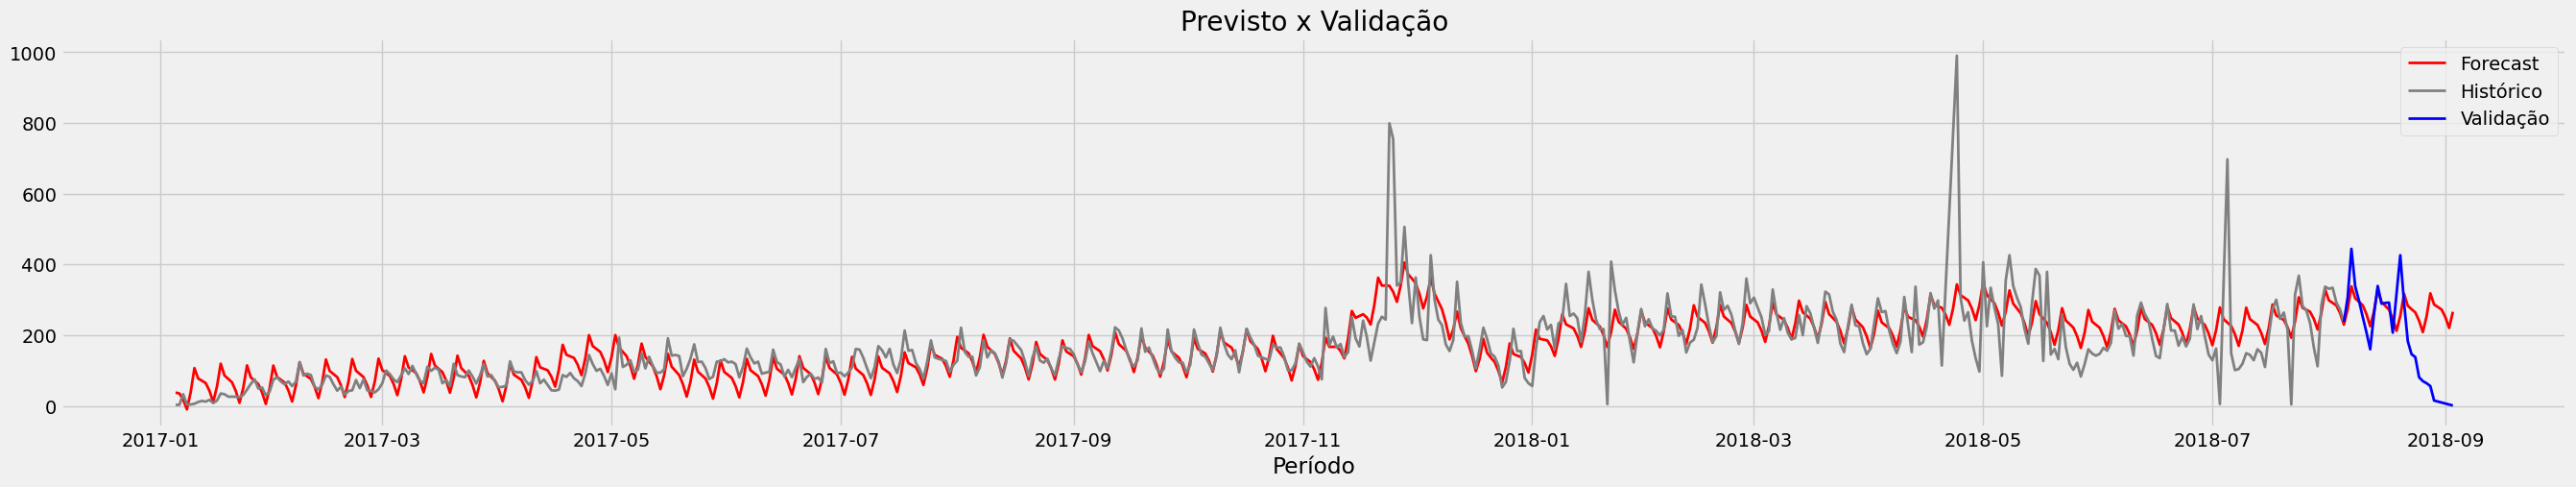

{'mse': 15713.360741838123, 'rmse': 119.23874410878085, 'mae': 66.90095633246194, 'mape': 0.6058130667448551, 'mdape': 0.21837003442720745, 'smape': 0.3807033962305439, 'coverage': 0.5088255676490971}


<Figure size 3000x500 with 0 Axes>

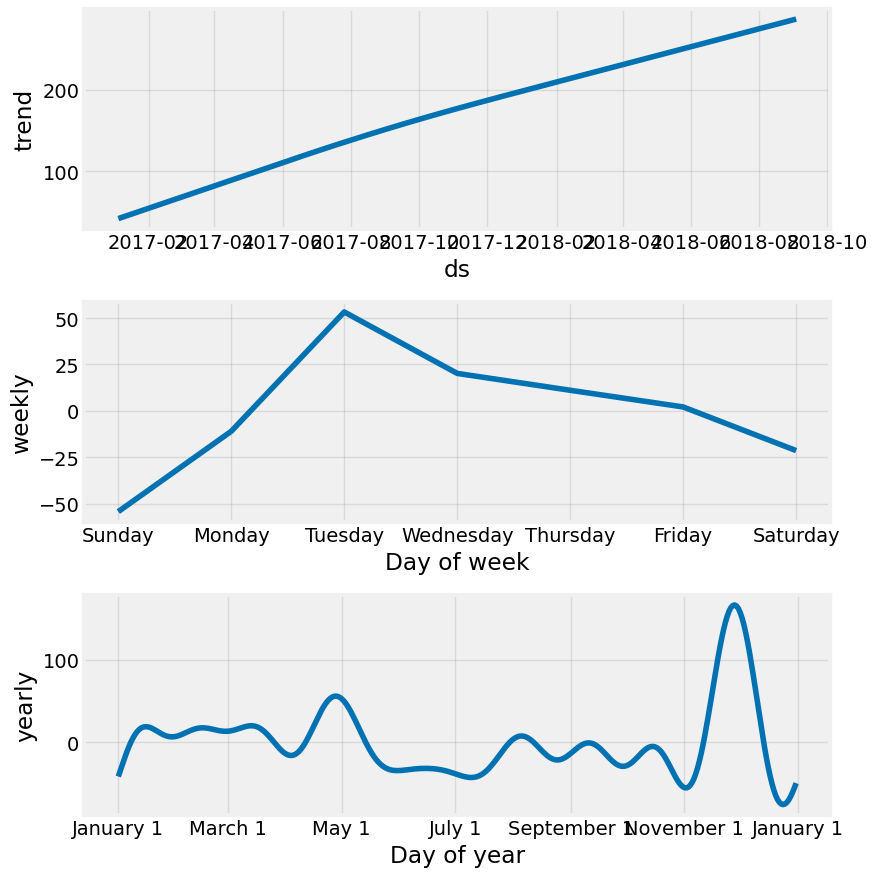

In [38]:


prophet_model = Prophet(seasonality_mode='additive',
            weekly_seasonality = True,
            daily_seasonality=False,
            changepoint_range=0.7,   #Define o intervalo dos dados de treinamento que serão utilizados 				 
                                               #para rastrear pontos de mudança , foi aplicado aqui 10% dos dados
                                               #considerando a sazonalidade anual.
            changepoint_prior_scale = 0.01,
            yearly_seasonality = 10,
            seasonality_prior_scale=1
            )
#Direcionando para ele  salvar os dados na pasta Models
mlflow.set_tracking_uri(Path(Path.cwd()).parent.joinpath("models").joinpath("mlruns").as_uri())
with mlflow.start_run(run_name="Forecast_Initial") as run:
    prophet_model.fit(train_prophet)

    # extract and log parameters such as changepoint_prior_scale in the mlflow run
    # model_params = {
    #     name: value for name, value in vars(prophet_model).items() if np.isscalar(value)
    # }
    mlflow.log_params(extract_params(prophet_model))
    cv_results = cross_validation( prophet_model, initial = '56 days', period = '14 days', horizon = '14 days' )
        
    # Calculate metrics from cv_results, then average each metric across all backtesting windows and log to mlflow
    cv_metrics = ["mse", "rmse","mae","mape", "mdape","smape","coverage"]
    metrics_results = performance_metrics(cv_results, metrics=cv_metrics)
    average_metrics = metrics_results.loc[:, cv_metrics].mean(axis=0).to_dict()
    mlflow.log_metrics(average_metrics)
    model_info = mlflow.prophet.log_model(prophet_model, "prophet-model",conda_env=condaEnv)
    future = prophet_model.make_future_dataframe(periods=len(teste),
                                 #freq='D',
                                 include_history=True)
    predictions = prophet_model.predict(future)

    figPath =Path(Path.cwd()).parent.joinpath("images\Components.png")
    ForecastPlotProphet(df_teste=teste,df_train=train,df_predict=predictions,HistorySlice=0)
    fig = prophet_model.plot_components(predictions)
    fig.savefig(figPath, dpi=150)
    mlflow.log_artifact(figPath)
    mlflow.end_run()
# Load saved model

# prophet_model_saved = mlflow.pyfunc.load_model(model_info.model_uri)
# predictions = prophet_model_saved.predict(future)


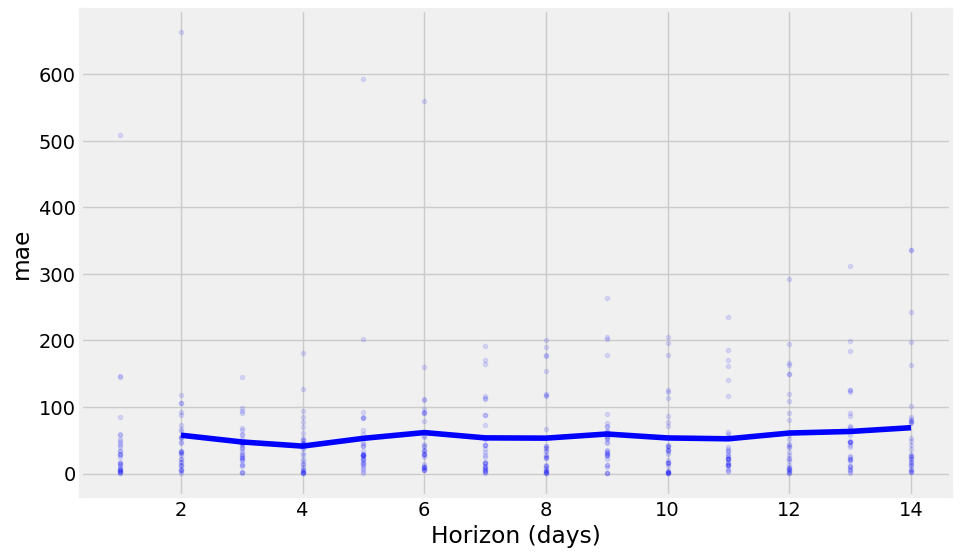

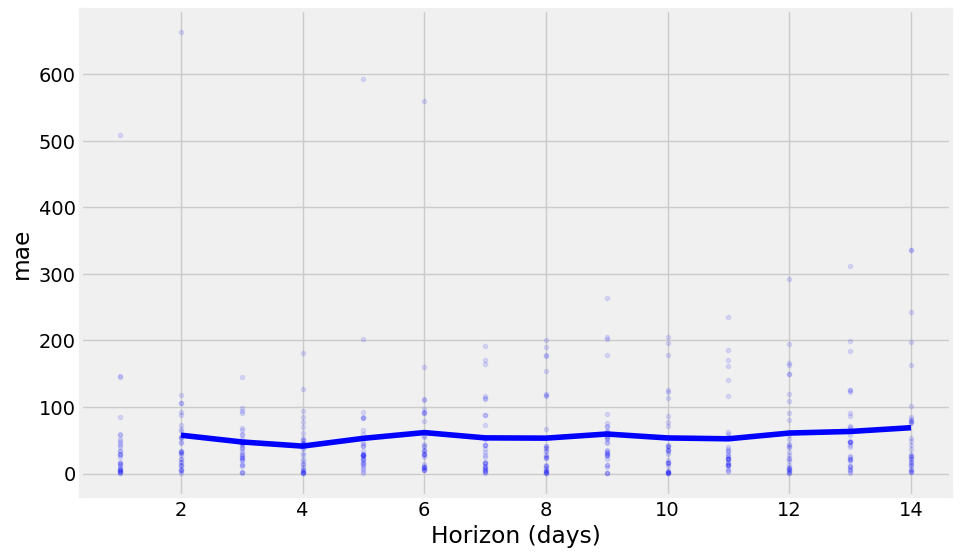

In [39]:
from prophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(cv_results)#, metric='mae')

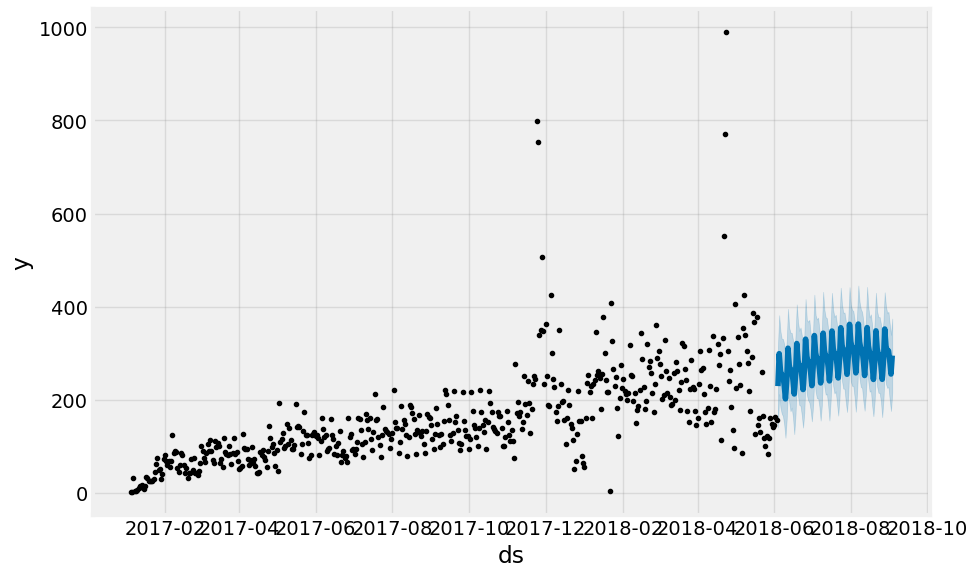

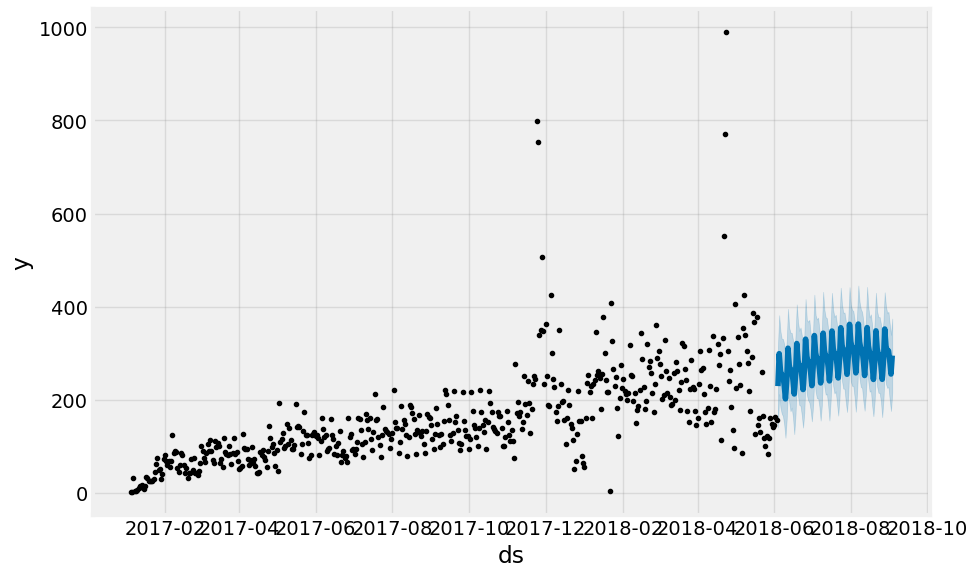

In [ ]:
prophet_model.plot(predictions)

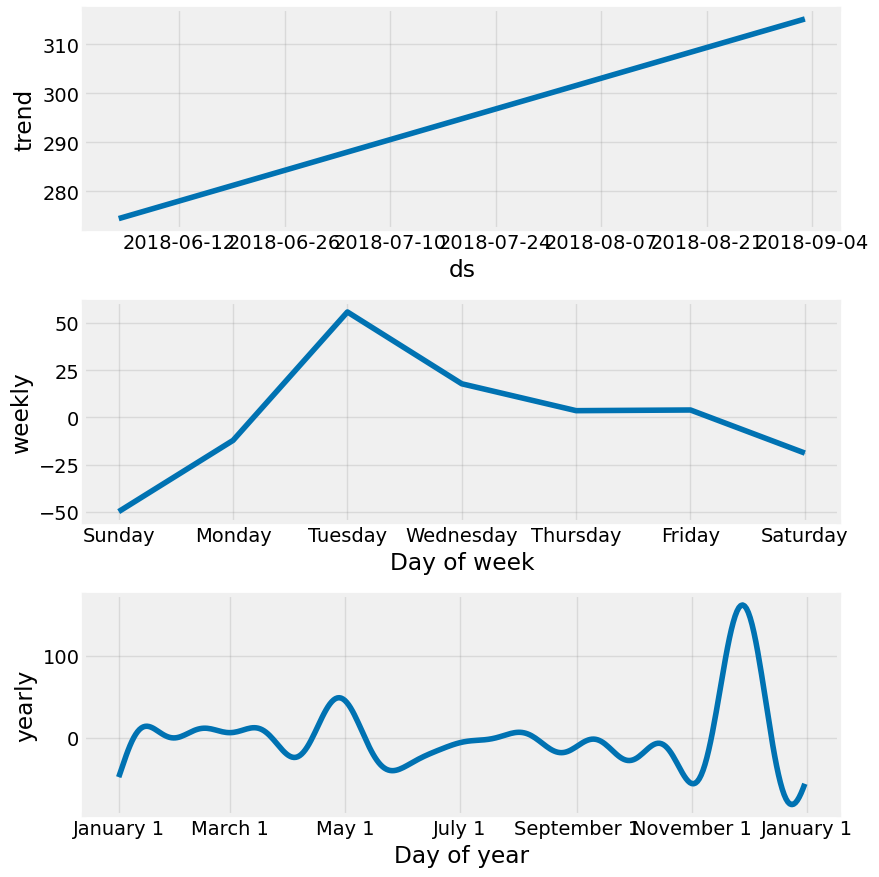

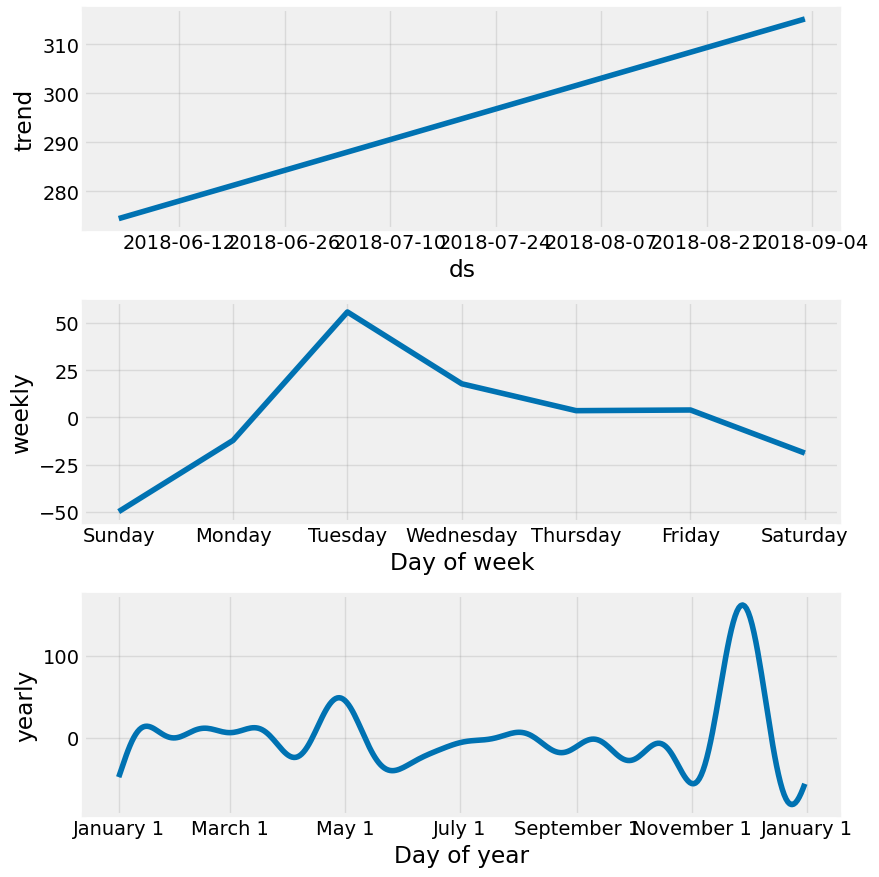

In [24]:
prophet_model.plot_components(predictions)

In [ ]:
prophet_model.plot(predictions[:])
plt.plot(teste, label='Valid', color = 'red', linewidth = 2)
plt.show()



In [ ]:

prophet_model_saved = mlflow.pyfunc.load_model(model_info.model_uri)
forecast = prophet_model_saved.predict(future)
Predict = forecast[['ds','yhat']].set_index('ds')
Predict.columns = ['Previsto']
# valid_prophet2 = valid_prophet
# valid_prophet2.columns = ['ds','Validação']

## Otimização de parâmetros

### Criando experimento

In [349]:

diretorio_anterior = Path(Path.cwd()).parent

# Create an experiment name, which must be unique and case sensitive
experiment_id = mlflow.create_experiment(
    "Forecast Otimização de parâmetros",
    #artifact_location=diretorio_anterior.joinpath("models").joinpath("mlruns").as_uri(),
    tags={"version": "v1", "priority": "P1"},
)
experiment = mlflow.get_experiment(experiment_id)
print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
print("Creation timestamp: {}".format(experiment.creation_time))

Name: Forecast Otimização de parâmetros
Experiment_id: 1
Artifact Location: file:///c:/WIMYD/MasterOfDices/models/mlruns/1
Tags: {'priority': 'P1', 'version': 'v1'}
Lifecycle_stage: active
Creation timestamp: 1684118474923


### Treino

In [225]:

param_grid = {'changepoint_range':[0.7, 1 ,0.5],
                           'changepoint_prior_scale': [0.04, 0.05, 0.06],
                           'yearly_seasonality':[3,10,15,20],
                           'seasonality_prior_scale': [0.5, 0.1, 1],

                           'daily_seasonality':[True,False]
              } #216 combinações de hiperpametros

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
# mlflow.set_tracking_uri(Path(Path.cwd()).parent.joinpath("models").as_uri())
# Use cross validation to evaluate all parameters
for i in range(len(all_params)):
    with mlflow.start_run(experiment_id="1",
                          #experiment_id=experiment.experiment_id,
                          run_name="Forecast_"+str(i)) as run:
        prophet_model = Prophet(weekly_seasonality = True, seasonality_mode ='additive', **all_params[i]).fit(train_prophet)  # Fit model with given params

        mlflow.log_params(extract_params(prophet_model))
        cv_results = cross_validation(
                                    prophet_model,
                                    initial = '56 days',
                                    period = '14 days' ,
                                    horizon = '14 days' )
            
        # Calculate metrics from cv_results, then average each metric across all backtesting windows and log to mlflow
        cv_metrics = ["mse", "rmse","mae","mape", "mdape","smape","coverage"]
        metrics_results = performance_metrics(cv_results, metrics=cv_metrics)
        average_metrics = metrics_results.loc[:, cv_metrics].mean(axis=0).to_dict()
        mlflow.log_metrics(average_metrics)
        model_info = mlflow.prophet.log_model(prophet_model, "prophet-model")
    run.end_run()

INFO:prophet:Making 32 forecasts with cutoffs between 2017-03-12 00:00:00 and 2018-05-20 00:00:00


  0%|          | 0/32 [00:24<?, ?it/s]

INFO:prophet:Making 32 forecasts with cutoffs between 2017-03-12 00:00:00 and 2018-05-20 00:00:00


  0%|          | 0/32 [00:22<?, ?it/s]

## Tabela com as metricas de todos os modelos

In [237]:
experiment_id = "1"
#run_id = "1"

metrics_exp = mlflow.search_runs(
    experiment_ids=experiment_id,
    run_view_type=mlflow.entities.ViewType.ALL,
    #run_ids=[run_id],
)

df_exp = pd.DataFrame(metrics_exp)
Top10_Models = df_exp[['run_id','tags.mlflow.runName','start_time',
       'end_time', 'metrics.mse', 'metrics.mdape', 'metrics.mape',
       'metrics.rmse', 'metrics.coverage', 'metrics.mae', 'metrics.smape',
       'params.changepoint_range','params.seasonality_prior_scale', 'params.yearly_seasonality', 'params.daily_seasonality',
       'params.weekly_seasonality', 'params.changepoint_prior_scale']].sort_values('metrics.mae').head(10)

Top10_Models

,run_id,tags.mlflow.runName,start_time,end_time,metrics.mse,metrics.mdape,metrics.mape,metrics.rmse,metrics.coverage,metrics.mae,metrics.smape,params.changepoint_range,params.seasonality_prior_scale,params.yearly_seasonality,params.daily_seasonality,params.weekly_seasonality,params.changepoint_prior_scale
183,3fb3d3444a3f4ffea298563c76778a2c,Forecast_32,2023-05-08 04:25:48.185000+00:00,2023-05-08 04:26:34.003000+00:00,6262.805211,0.218397,0.382378,76.156070,0.497159,46.395817,0.256785,0.7,0.1,10,True,True,0.05
63,f38c0e55c3f5499fb0d0c752d0c43f40,Forecast_152,2023-05-08 13:59:55.985000+00:00,2023-05-08 14:00:53.814000+00:00,6282.017201,0.218735,0.383614,76.319368,0.501967,46.488437,0.256660,0.5,0.1,10,True,True,0.04
15,431a29379d2d4db3825d03078f6807ab,Forecast_200,2023-05-08 15:02:28.788000+00:00,2023-05-08 15:03:31.023000+00:00,6324.977691,0.220984,0.385493,76.558067,0.505026,46.714467,0.259432,0.5,0.1,10,True,True,0.06
207,32cae482815c49d89a4d52f1466373b2,Forecast_8,2023-05-08 04:04:08.919000+00:00,2023-05-08 04:04:54.780000+00:00,6312.501560,0.219317,0.387412,76.563918,0.505682,46.842718,0.262069,0.7,0.1,10,True,True,0.04
39,7e49791abbdc4bbfa9f463a45d5068b2,Forecast_176,2023-05-08 14:30:16.168000+00:00,2023-05-08 14:31:18.480000+00:00,6374.859985,0.225253,0.386200,76.953132,0.501311,47.046337,0.261323,0.5,0.1,10,True,True,0.05
159,975d2c95429a427aa22033213d2671dc,Forecast_56,2023-05-08 04:48:01.038000+00:00,2023-05-08 04:48:48.110000+00:00,6391.065177,0.222508,0.387381,77.056103,0.502622,47.211605,0.264715,0.7,0.1,10,True,True,0.06
38,bc52b4c532bb4efa827a31e9d9b29931,Forecast_177,2023-05-08 14:31:35.434000+00:00,2023-05-08 14:32:37.823000+00:00,6417.345678,0.220149,0.387333,77.193422,0.494318,47.232845,0.265451,0.5,0.1,10,False,True,0.05
87,720be2c5c58b4210965a1b597c7756af,Forecast_128,2023-05-08 13:31:04.213000+00:00,2023-05-08 13:32:02.003000+00:00,6388.945052,0.225620,0.388521,77.026391,0.500219,47.274720,0.264966,1,0.1,10,True,True,0.06
110,5223e8eeb4d64e4c8fd0f43346466619,Forecast_105,2023-05-08 13:05:08.962000+00:00,2023-05-08 13:05:59.498000+00:00,6413.509268,0.228277,0.388503,77.207578,0.501530,47.322678,0.267587,1,0.1,10,False,True,0.05
111,171ab81413784fbf978c0994cfcd744d,Forecast_104,2023-05-08 13:04:05.427000+00:00,2023-05-08 13:04:57.460000+00:00,6372.413807,0.221376,0.389910,76.967628,0.509178,47.344971,0.266999,1,0.1,10,True,True,0.05


In [244]:
Top10_Models['run_id'][0:1].values[0]

'3fb3d3444a3f4ffea298563c76778a2c'

In [215]:
#@title Validação Cruzada Prophet

# cluster = LocalCluster()
# client = Client(cluster)
"""
m = Prophet(seasonality_mode='additive',
            weekly_seasonality = True,
            changepoint_range=0.7,   #Define o intervalo dos dados de treinamento que serão utilizados 				 
                                               #para rastrear pontos de mudança , foi aplicado aqui 10% dos dados
                                               #considerando a sazonalidade anual.
            changepoint_prior_scale = 0.05,
            yearly_seasonality = 15,
            seasonality_prior_scale=1
            ).fit(train_prophet)
"""

            
param_grid = param_grid = {'changepoint_range':[1 ,0.5],
                           'changepoint_prior_scale': [0.04],
                           'yearly_seasonality':[10],
                           'seasonality_prior_scale': [ 0.1],

                           'daily_seasonality':[True]
              }

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
mse = []
mae = []
mape = []
mdape = []	
smape = []
coverage = []

# Use cross validation to evaluate all parameters
for i in range(len(all_params)):
    m = Prophet(weekly_seasonality = True,
                seasonality_mode ='additive', **all_params[i]).fit(train_prophet)  # Fit model with given params
    df_cv = cross_validation(m,
                            initial = '56 days',
                            period = '14 days' ,
                            horizon = '14 days'
                             #parallel="dask"
                             ) #Periodos de 1 semana e horizonte de 1 semana em intevalos de 15 min
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    mse.append(df_p['mse'].values[0])
    mae.append(df_p['mae'].values[0])
    mape.append(df_p['mape'].values[0])
    mdape.append(df_p['mdape'].values[0])	
    smape.append(df_p['smape'].values[0])
    coverage.append(df_p['coverage'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['mse'] = mse
tuning_results['mae'] = mae
tuning_results['mape'] = mape
tuning_results['mdape'] = mdape
tuning_results['smape'] = smape
tuning_results['coverage'] = coverage
print(tuning_results)
# client.close()
# cluster.close()

INFO:prophet:Making 32 forecasts with cutoffs between 2017-03-12 00:00:00 and 2018-05-20 00:00:00


  0%|          | 0/32 [00:06<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x000002B774805168>
Traceback (most recent call last):
  File "c:\Users\chpsi\anaconda3\envs\Forecast\lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "c:\Users\chpsi\anaconda3\envs\Forecast\lib\site-packages\tqdm\notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'
INFO:prophet:Making 32 forecasts with cutoffs between 2017-03-12 00:00:00 and 2018-05-20 00:00:00


  0%|          | 0/32 [00:06<?, ?it/s]

   changepoint_range  changepoint_prior_scale  yearly_seasonality  \
0                1.0                     0.04                  10   
1                0.5                     0.04                  10   

   seasonality_prior_scale  daily_seasonality       rmse          mse  \
0                      0.1               True  81.949284  6715.685086   
1                      0.1               True  80.594633  6495.494837   

         mae      mape     mdape     smape  coverage  
0  48.159410  0.385894  0.211953  0.270910  0.488839  
1  46.689811  0.377855  0.203919  0.257525  0.511161  


In [216]:
tuning_results

,changepoint_range,changepoint_prior_scale,yearly_seasonality,seasonality_prior_scale,daily_seasonality,rmse,mse,mae,mape,mdape,smape,coverage
0,1.0,0.04,10,0.1,True,81.949284,6715.685086,48.159410,0.385894,0.211953,0.270910,0.488839
1,0.5,0.04,10,0.1,True,80.594633,6495.494837,46.689811,0.377855,0.203919,0.257525,0.511161


In [ ]:
tuning_results.sort_values('rmse')

,changepoint_range,changepoint_prior_scale,yearly_seasonality,seasonality_prior_scale,daily_seasonality,rmse
152,0.5,0.04,10,0.1,True,93.682833
153,0.5,0.04,10,0.1,False,95.878621
200,0.5,0.06,10,0.1,True,96.091653
129,1.0,0.06,10,0.1,False,96.235491
104,1.0,0.05,10,0.1,True,96.369701
...,...,...,...,...,...,...
85,1.0,0.04,15,0.5,False,228.456286
160,0.5,0.04,15,1.0,True,231.864322
136,1.0,0.06,15,1.0,True,233.239968
161,0.5,0.04,15,1.0,False,236.639369


In [ ]:
#@title Treino Prophet com Hiperparametros otimizados
m = Prophet(changepoint_range=0.5,   #Define o intervalo dos dados de treinamento que serão utilizados 				 
                                               #para rastrear pontos de mudança , foi aplicado aqui 10% dos dados
                                               #considerando a sazonalidade anual.
            daily_seasonality=True,
            weekly_seasonality = True,
            changepoint_prior_scale = 0.04,
            seasonality_mode='additive',
            yearly_seasonality = 10,
            seasonality_prior_scale=0.1
            ).fit(train_prophet)

with open(Pasta+'/Forecast_ProphetModelVaiPet_otimizado.json', 'w') as fout:
    fout.write(model_to_json(m))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpmj6aoq1g/dejzd5se.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmj6aoq1g/l_yggwgb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30775', 'data', 'file=/tmp/tmpmj6aoq1g/dejzd5se.json', 'init=/tmp/tmpmj6aoq1g/l_yggwgb.json', 'output', 'file=/tmp/tmpmj6aoq1g/prophet_modelkqtugse9/prophet_model-20221217025654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:56:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:56:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


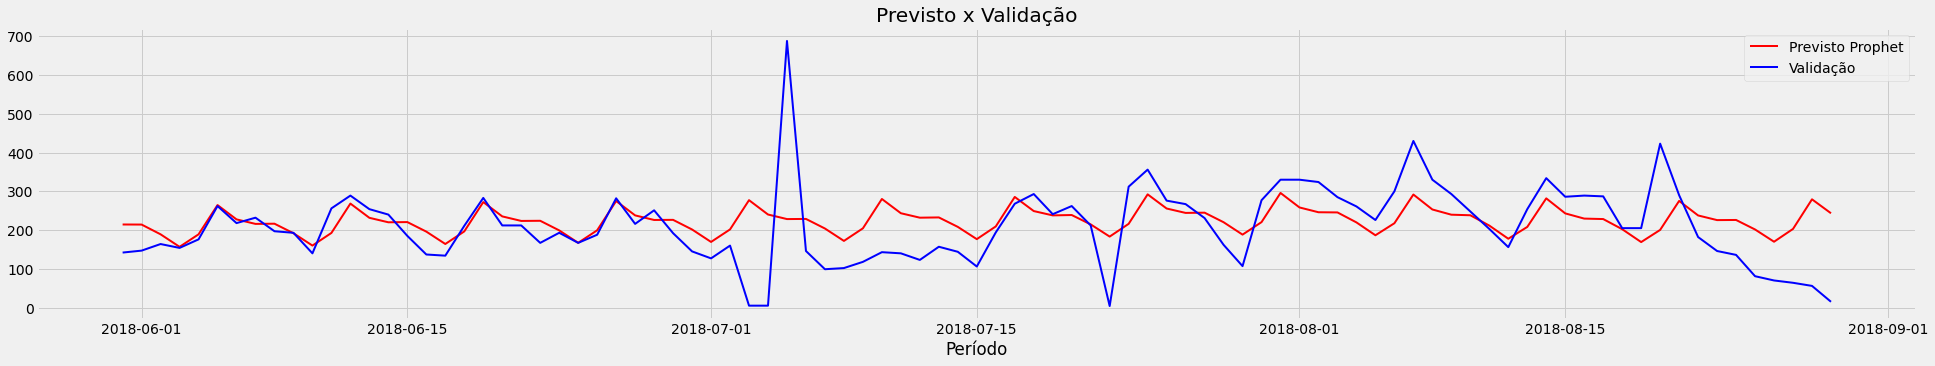

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_regression.py:95: FutureWarning:

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_regression.py:95: FutureWarning:

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_regression.py:95: FutureWarning:

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.

/usr/local/lib/python3.8/dist-packages/skle

,Model,R2_score,MAE,MSE,RMSE
0,prophet,0.127028,62.633206,8864.63305,94.15218


In [ ]:
#@title Previsto x Teste - Prophet Otimizado

#Carregando o arquivo do modelo
with open(Pasta+'/Forecast_ProphetModelVaiPet_otimizado.json', 'r') as fin:
    m = model_from_json(fin.read()) # Load model

# construção do dataset de teste para alimentar o modelo
future = m.make_future_dataframe(periods=periods,
                                 #freq='D',
                                 include_history=False)

# realiza previsão
forecast = m.predict(future)

Predict = forecast[['ds','yhat']].set_index('ds')
Predict.columns = ['Previsto']
valid_prophet2 = valid_prophet#.set_index('ds')
valid_prophet2.columns = ['Validação']

rcParams['figure.figsize'] = 30, 5
plt.style.use('fivethirtyeight')
plt.title('Previsto x Validação')
plt.plot(Predict, label='Previsto Prophet', color = 'red', linewidth = 2)
#plt.plot(train[500:], label='Histórico', color = 'gray', linewidth = 2)
plt.plot(valid_prophet2, label='Validação', color = 'blue', linewidth = 2)
plt.xlabel("Período")
plt.legend(loc='best')
plt.show()
Results = MetricsTable('prophet',valid_prophet2['Validação'].values,Predict['Previsto'].values)
Residuals_Prophet=pd.DataFrame(Predict['Previsto'][:].values - valid_prophet2['Validação'][:].values,index=Predict.index,columns=["Residuals Prophet"])
prophetResults = MetricsTable('prophet',valid_prophet2['Validação'][:].values,Predict['Previsto'][:].values)
prophetResults

